# 0.0 - Imports

In [96]:
import os
import re
import pickle
import warnings

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import matplotlib.ticker       as mtick
import seaborn                 as sns
import lightgbm                as lgb
import xgboost                 as xgb

from scipy                     import stats
from IPython.display           import display, HTML
from xgboost                   import XGBRegressor, plot_importance
from sklearn.model_selection   import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing     import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model      import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.ensemble          import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.metrics           import make_scorer, mean_absolute_error, mean_squared_error, r2_score


# 0.1 - Helper Function

In [2]:
# %matplotlib inline
# %pylab inline
    
# plt.style.use('bmh')
# plt.rcParams['figure.figsize'] = [25, 12]
# plt.rcParams['font.size'] = 24
    
# display (HTML('<style>.container { width:100% !important; }</style>'))
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# pd.set_option('display.expand_frame_repr', False)

In [210]:
pd.set_option('display.float_format', '{:,.2f}'.format)

display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output { max-height: 1000px !important; }</style>"))


def descriptive_statistics(df):
    num_attributes = df.select_dtypes(include=['int64', 'float64'])
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 25))).T
    d8 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 50))).T
    d9 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 75))).T
    d10 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 90))).T
    d11 = pd.DataFrame(num_attributes.apply(lambda x: np.percentile(x, 99))).T
    de_table = pd.concat([d4, ct1, ct2, d1, d5, d6, d2, d7, d8, d9, d10, d11, d3]).T.reset_index()
    de_table.columns = ['attributes', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis', 'min', '25%', '50%', '75%', '90%', '99%', 'max']
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.options.display.float_format = '{:,.2f}'.format
    return de_table

pd.options.display.float_format = None


from IPython.display import HTML
HTML('<style>.container { width:100% !important; }</style>')
plt.rcParams['figure.dpi'] = 100

# Define a função para formatar o eixo x em milhares
def milhares_x(x, pos):
    return '{:.0f}k'.format(x/1000)

# Define a função para formatar o eixo x em milhões
def milhoes_x(x, pos):
    return '{:.0f}m'.format(x/1000000)

# Define a função para formatar o eixo y em milhares
def milhares_y(y, pos):
    return '{:.0f}k'.format(y/1000)

# Define a função para formatar o eixo y em milhões
def milhoes_y(y, pos):
    return '{:.0f}m'.format(y/1000000)

def plot_count_percentage(data, x, title, ax, dp=2, percent_fontsize=8):
    sns.countplot(x=x, data=data, ax=ax, palette='Greens_r', order=data[x].value_counts().index)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)

    total = len(data[x])
    for p in ax.patches:
        percentage = p.get_height() / total
        formatted_percentage = f"{percentage:.{dp}%}"
        ax.text(p.get_x() + p.get_width() / 2,
                p.get_height(),
                formatted_percentage,
                ha='center',
                va='bottom',
                fontsize=percent_fontsize)

sns.set_theme(style="whitegrid")


def plot_count_percentage_horizontal(data, x, title, ax, dp=2, percent_fontsize=10, top_n=None, show_absolute=True, show_percent=True):
    if top_n is not None:
        data_subset = data[x].value_counts().head(top_n).reset_index()
        data_subset.columns = [x, 'Count']
    else:
        data_subset = data[x].value_counts().reset_index()
        data_subset.columns = [x, 'Count']

    sns.barplot(x='Count', y=x, data=data_subset, ax=ax, palette='Greens_r')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)

    total_subset = len(data_subset)

    for p in ax.patches:
        width = p.get_width()
        index = int(p.get_y())

        if 0 <= index < len(data_subset):
            model_name = data_subset.loc[index, x]
            total = len(data[x])  # Use the total count from the original dataset
            percentage = (width / total) * 100

            label = ''
            if show_absolute:
                label += f'{width:.0f}'
            if show_absolute and show_percent:
                label += ' '
            if show_percent:
                label += f'({percentage:.2f}%)'

            ax.annotate(label,
                        (width, p.get_y() + p.get_height() / 2),
                        va='center', ha='left', xytext=(2, 0), textcoords='offset points')

def identificar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 5 * IQR
    limite_superior = Q3 + 5 * IQR
    outliers = (series < limite_inferior) | (series > limite_superior)
    return outliers

def create_counts_df(data):
    counts_df = data.groupby(['TipoVendedor', 'TipoAnuncio']).size().unstack(fill_value=0)
    return counts_df


def plot_combined_bar_chart(data, ax, title, dp=2, percent_fontsize=12):
    counts_df = create_counts_df(data)
    counts_df.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette("Greens_r", len(counts_df.columns)))

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('TipoVendedor')

    plt.xticks(rotation=0)
    plt.legend(title='TipoAnuncio', bbox_to_anchor=(1.05, 1), loc='upper left')

    total = counts_df.sum(axis=1).sum()
    for p in ax.patches:
        percentage = p.get_height() / total
        formatted_percentage = f"{percentage:.{dp}%}"

        # Adicione esta verificação para evitar mostrar 0,00%
        if percentage > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    p.get_height(),
                    formatted_percentage,
                    ha='center',
                    va='bottom',
                    fontsize=percent_fontsize)

# 0.3 - Data

## 0.3.1 - Upload Data

In [4]:
df_raw = pd.read_csv(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\Data\WebMotors - All.csv', encoding='utf-8')

## 0.3.2 - Split data into train and test

In [491]:
# Separating target variable
X = df_raw.drop('Valor', axis=1)
Y = df_raw['Valor']

# Spliting train and test datasets
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concatenating target variable into train and test datasets
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

# 1.0 - Data Description

In [6]:
df1 = df_train.copy()

## 1.1 - Data Types

In [7]:
df1.dtypes

UniqueId           int64
Titulo            object
Marca             object
Modelo            object
Versao            object
AnoFabricacao      int64
AnoModelo        float64
Cidade            object
Estado            object
KM               float64
Cambio            object
NumeroPortas       int64
TipoCorpo         object
UnicoDono           bool
IPVAPago            bool
Licenciado          bool
Blindado          object
Cor               object
TipoVendedor      object
TipoAnuncio       object
NomeFantasia      object
Fipe               int64
Link              object
Valor            float64
dtype: object

In [8]:
df1['AnoModelo'] = df1['AnoModelo'].astype('int64')

## 1.2 - Data Dimensions

In [9]:
print(f'Number of Columns: {df1.shape[1]}')
print(f'Number of Rows:    {df1.shape[0]:n}')

Number of Columns: 24
Number of Rows:    288748


## 1.3 - Check NA

In [10]:
df1.isna().sum()

UniqueId             0
Titulo               0
Marca                0
Modelo               0
Versao               0
AnoFabricacao        0
AnoModelo            0
Cidade               0
Estado               0
KM                   0
Cambio               0
NumeroPortas         0
TipoCorpo            8
UnicoDono            0
IPVAPago             0
Licenciado           0
Blindado             0
Cor                  0
TipoVendedor         0
TipoAnuncio          0
NomeFantasia     62129
Fipe                 0
Link                 0
Valor                0
dtype: int64

In [11]:
df1['NomeFantasia'] = df1['NomeFantasia'].fillna('PF')
df1.isna().sum()

UniqueId         0
Titulo           0
Marca            0
Modelo           0
Versao           0
AnoFabricacao    0
AnoModelo        0
Cidade           0
Estado           0
KM               0
Cambio           0
NumeroPortas     0
TipoCorpo        8
UnicoDono        0
IPVAPago         0
Licenciado       0
Blindado         0
Cor              0
TipoVendedor     0
TipoAnuncio      0
NomeFantasia     0
Fipe             0
Link             0
Valor            0
dtype: int64

## 1.4 - Descriptive statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1 - Numerical Attributes

In [13]:
descriptive_statistics(num_attributes)

,attributes,range,media,mediana,std,skew,kurtosis,min,25%,50%,75%,90%,99%,max
0,UniqueId,"48,658,445.00","49,131,068.23","49,883,439.50","2,509,150.78",-6.72,70.43,"1,771,361.00","49,024,891.00","49,883,439.50","50,242,989.75","50,363,750.60","50,415,448.59","50,429,806.00"
1,AnoFabricacao,98.00,"2,017.01","2,018.00",5.82,-3.75,25.68,"1,926.00","2,015.00","2,018.00","2,021.00","2,022.00","2,023.00","2,024.00"
2,AnoModelo,98.00,"2,017.60","2,019.00",5.88,-3.77,25.83,"1,926.00","2,015.00","2,019.00","2,021.00","2,023.00","2,023.00","2,024.00"
3,KM,"2,147,483,647.00","137,181.15","65,000.00","7,473,249.99",172.75,"35,542.38",0.00,"40,451.00","65,000.00","100,000.00","142,000.00","261,225.73","2,147,483,647.00"
4,NumeroPortas,4.00,3.73,4.00,0.83,-3.21,9.88,0.00,4.00,4.00,4.00,4.00,4.00,4.00
5,Fipe,"2,937,681.00",230.91,103.00,"11,190.23",184.35,"38,148.01",57.00,99.00,103.00,109.00,122.00,666.00,"2,937,738.00"
6,Valor,"1,111,107,168.00","226,940.32","82,900.00","7,978,803.52",117.15,"15,491.45","4,000.00","57,000.00","82,900.00","125,889.00","204,990.00","717,054.70","1,111,111,168.00"


Text(0.5, 1.0, 'Fipe')

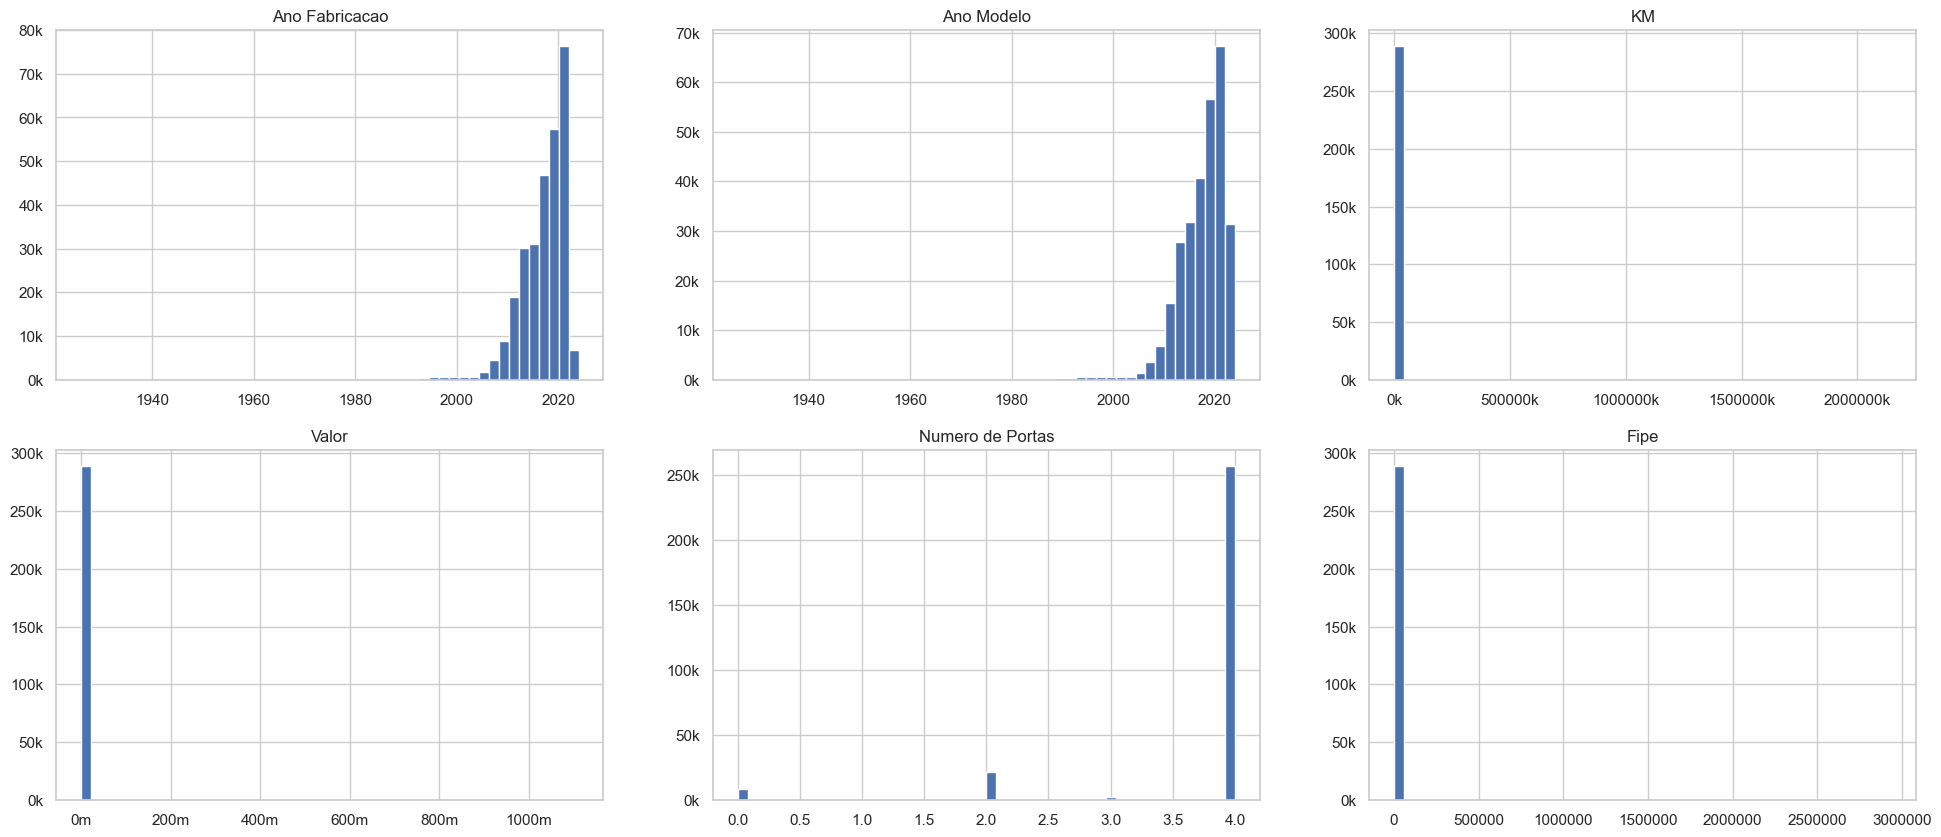

In [14]:
plt.subplot(2, 3, 1)
df1['AnoFabricacao'].hist(bins= 50, figsize=(24,12))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Fabricacao")

plt.subplot(2, 3, 2)
df1['AnoModelo'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Modelo")

plt.subplot(2, 3, 3)
df1['KM'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("KM")

plt.subplot(2, 3, 4)
df1['Valor'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhoes_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Valor")

plt.subplot(2, 3, 5)
df1['NumeroPortas'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Numero de Portas")

plt.subplot(2, 3, 6)
df1['Fipe'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Fipe")


*   The histogram presented allows us to identify that the data for the Fipe, KM, and Valor features are mostly concentrated in the first bin.
*   Such a wide variation, combined with a distribution that is so heavily skewed toward the first bin, indicates the presence of outliers.
* The distribution of 'Ano Modelo' and 'Ano Fabricação' is largely concentrated after 2000.

### 1.4.2 - Categorical Attributes

In [15]:
cat_attributes.describe().T

,count,unique,top,freq
Titulo,288748,7104,FIAT MOBI 1.0 EVO FLEX LIKE. MANUAL,3245
Marca,288748,108,VOLKSWAGEN,44481
Modelo,288748,1058,ONIX,11062
Versao,288748,6262,1.0 12V MPI TOTALFLEX 4P MANUAL,3406
Cidade,288748,1710,São Paulo,46413
Estado,288748,27,São Paulo (SP),126704
Cambio,288748,7,Automática,166424
TipoCorpo,288740,10,Utilitário esportivo,103078
UnicoDono,288748,2,False,229011
IPVAPago,288748,2,False,189183


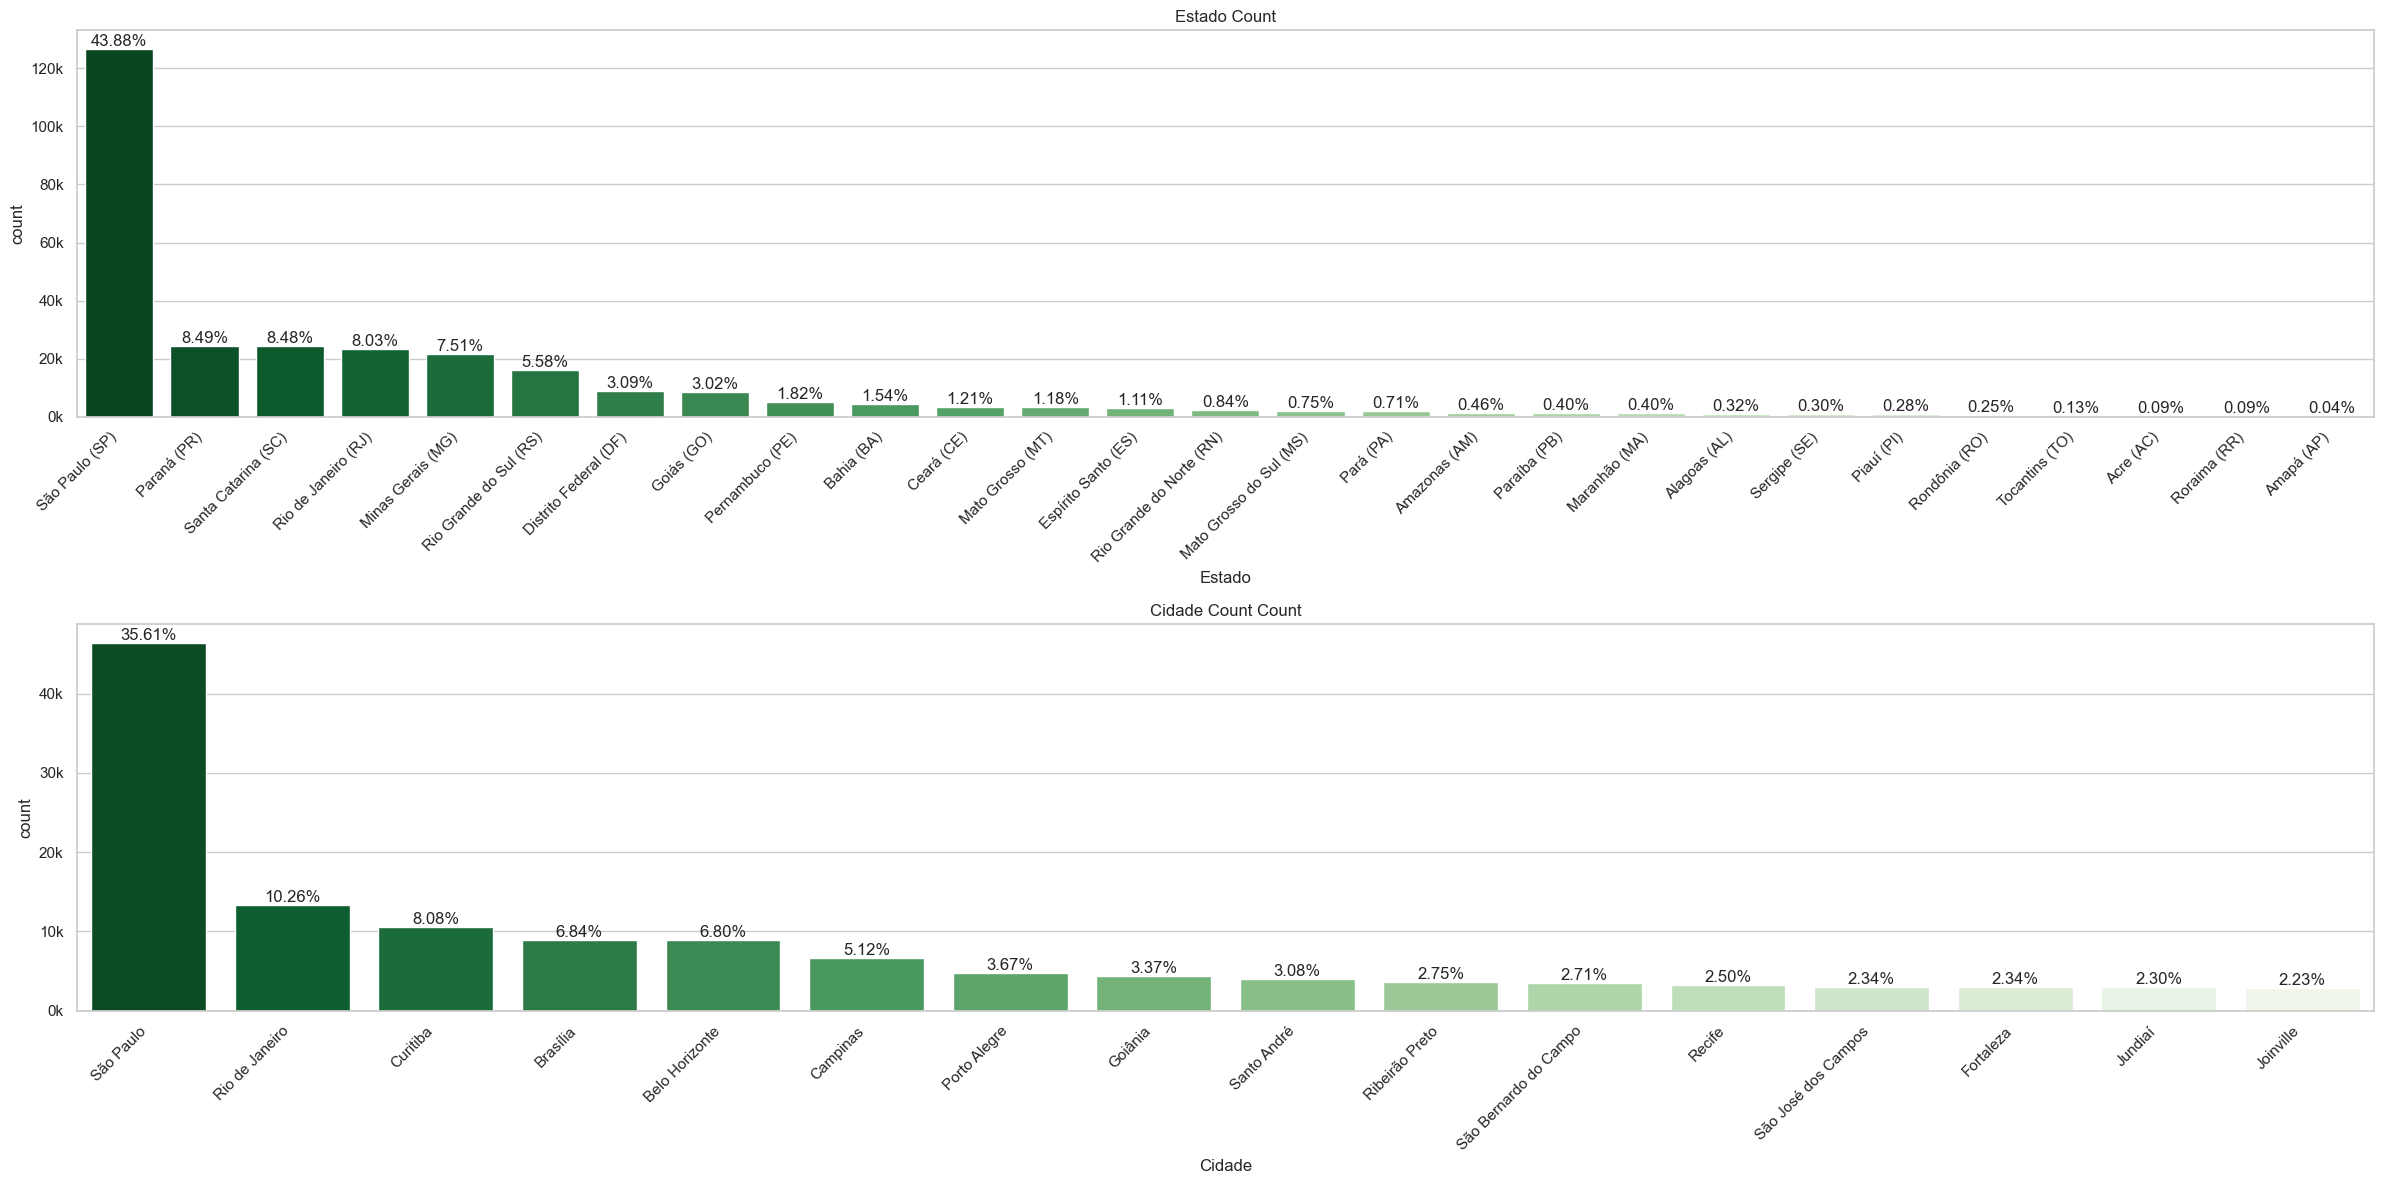

In [16]:
df_aux = df1['Cidade'].value_counts(normalize=True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_cidades = df_aux['Cidade']
df_aux2 = df1[df1['Cidade'].isin(top_cidades)]

fig, axs = plt.subplots(2, 1, figsize=(24,12))

plot_count_percentage(df1, 'Estado', 'Estado Count', axs[0], 2, 12)
plot_count_percentage(df_aux2, 'Cidade', 'Cidade Count Count', axs[1], 2, 12)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

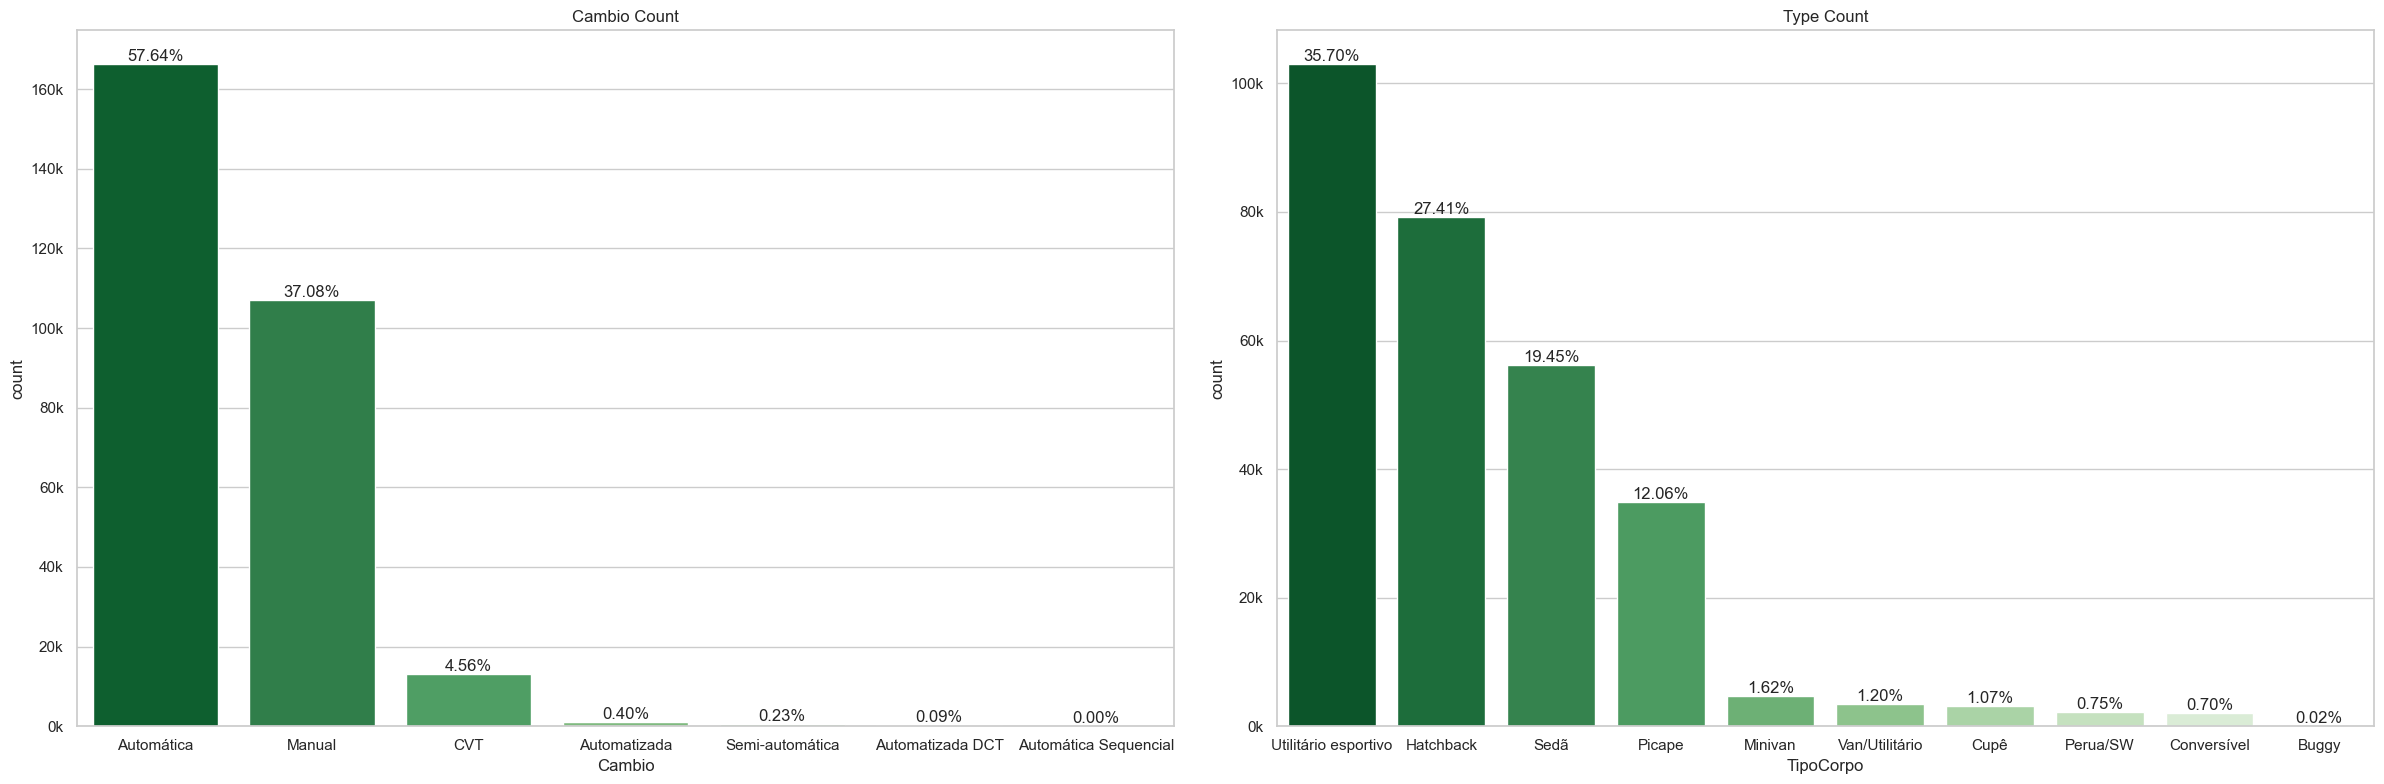

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

plot_count_percentage(df1, 'Cambio', 'Cambio Count', axs[0], 2, 12)
plot_count_percentage(df1, 'TipoCorpo', 'Type Count', axs[1], 2, 12)

plt.tight_layout()
plt.show()

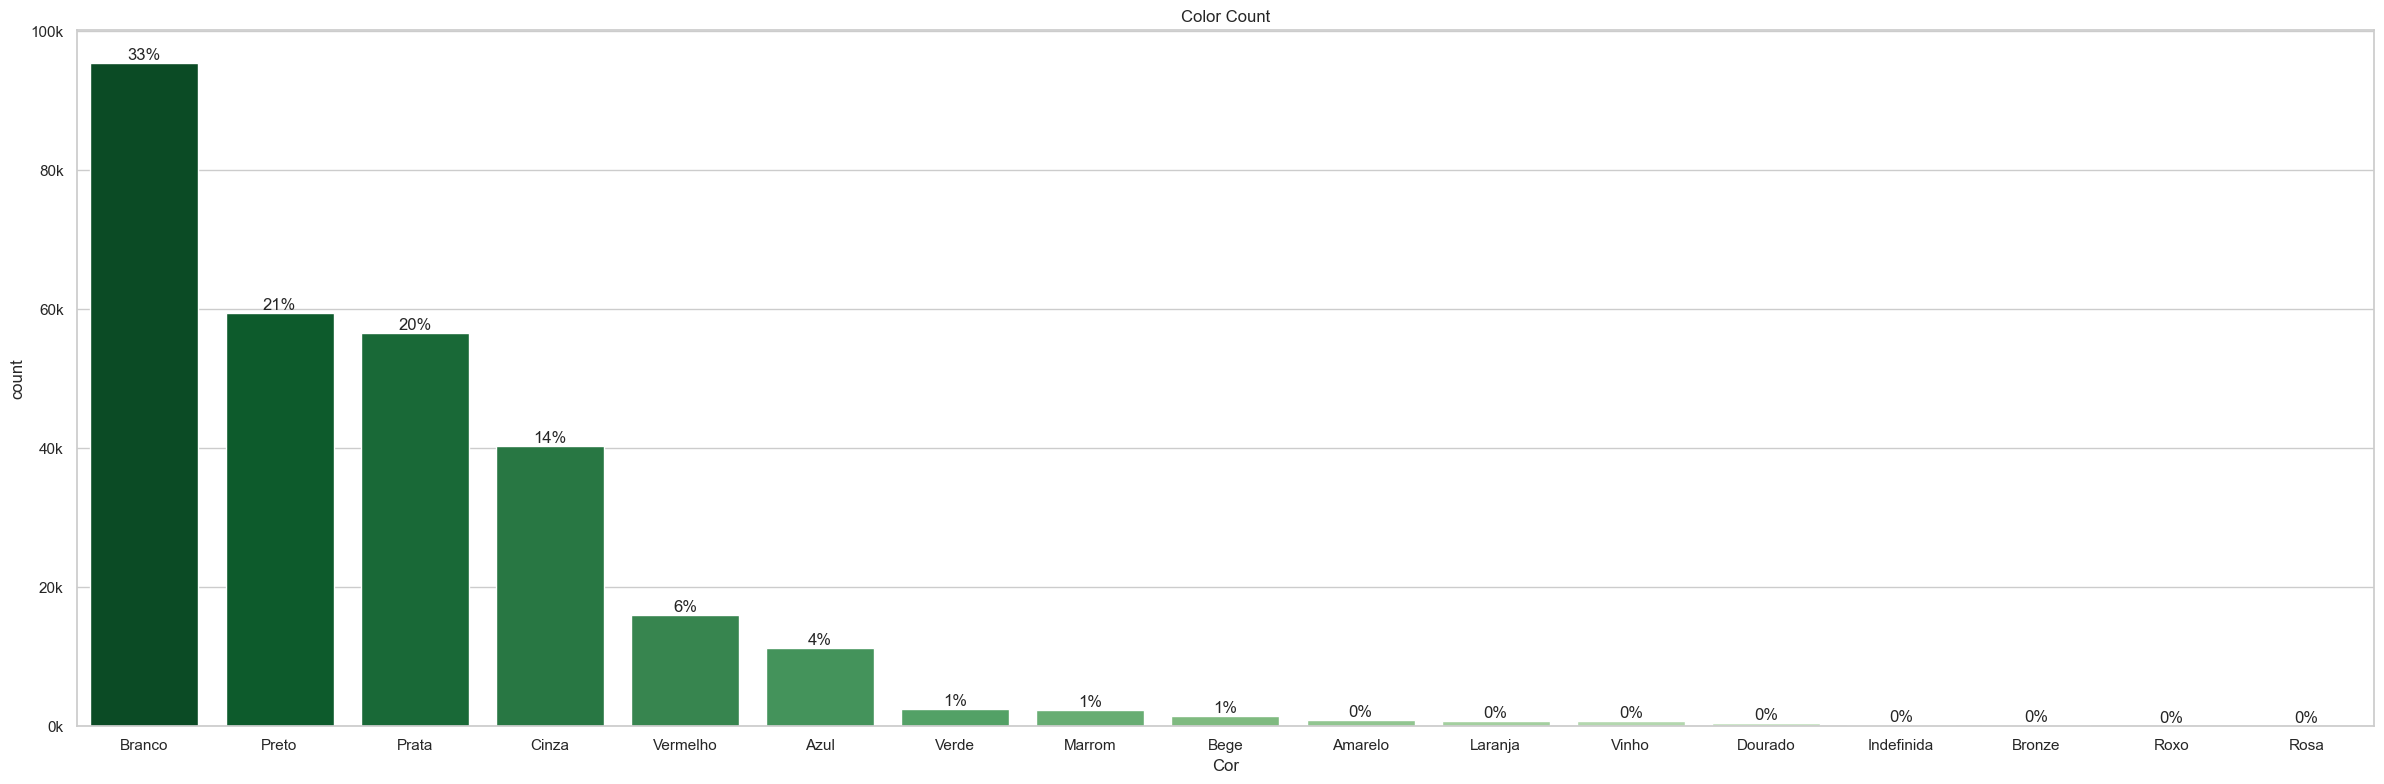

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(24,8))

plot_count_percentage(df1, 'Cor', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

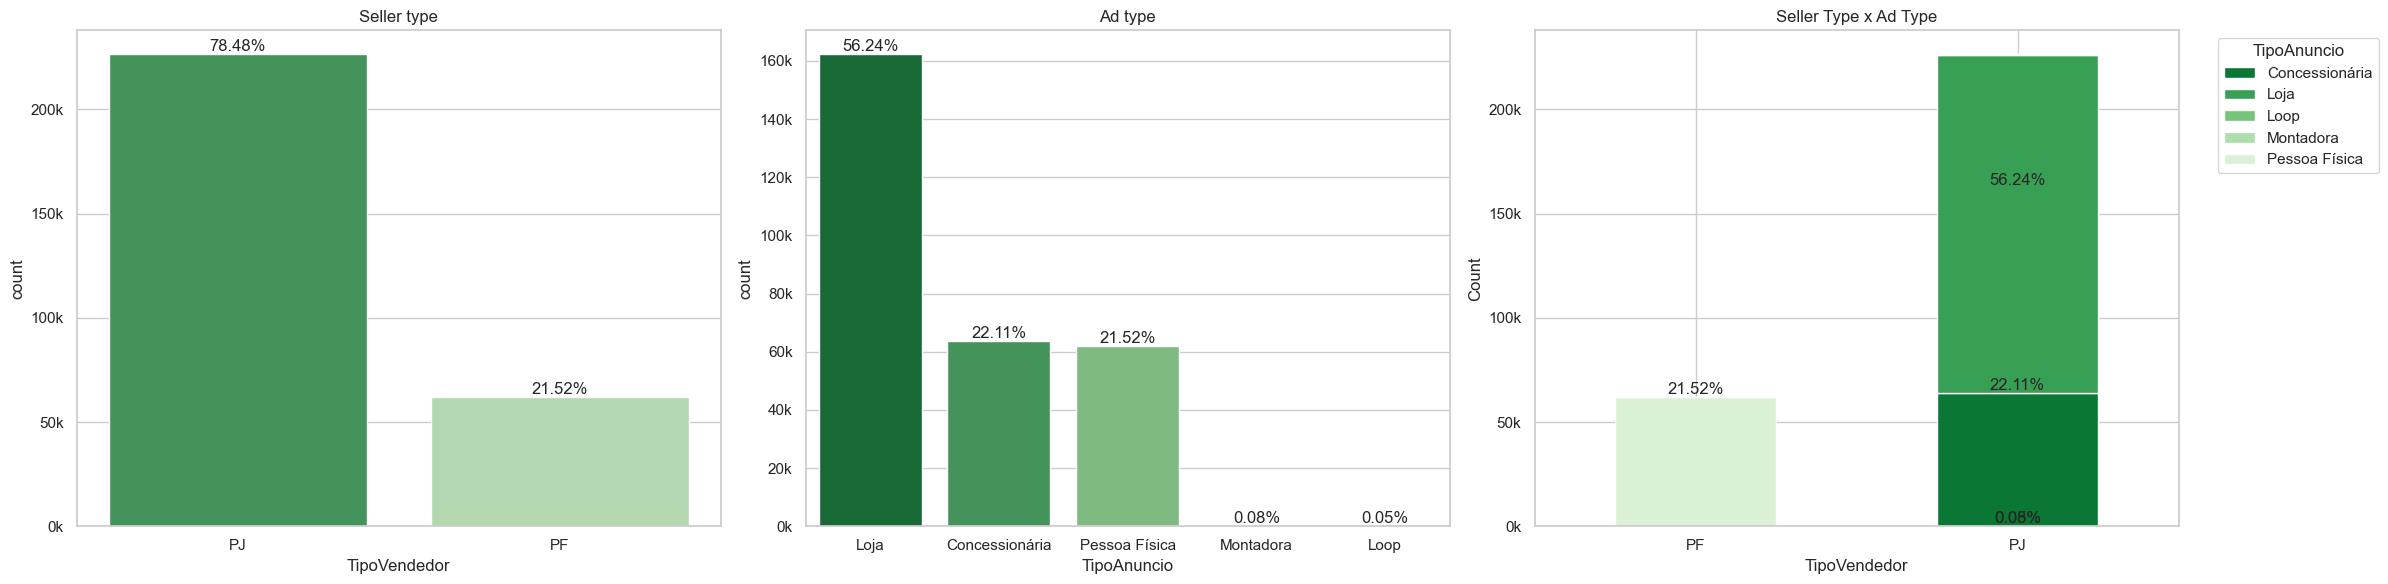

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot_count_percentage(df1, 'TipoVendedor', 'Seller type', axs[0], 2, 12)
plot_count_percentage(df1, 'TipoAnuncio', 'Ad type', axs[1], 2, 12)
plot_combined_bar_chart(df1, axs[2], 'Seller Type x Ad Type')

plt.tight_layout()
plt.show()

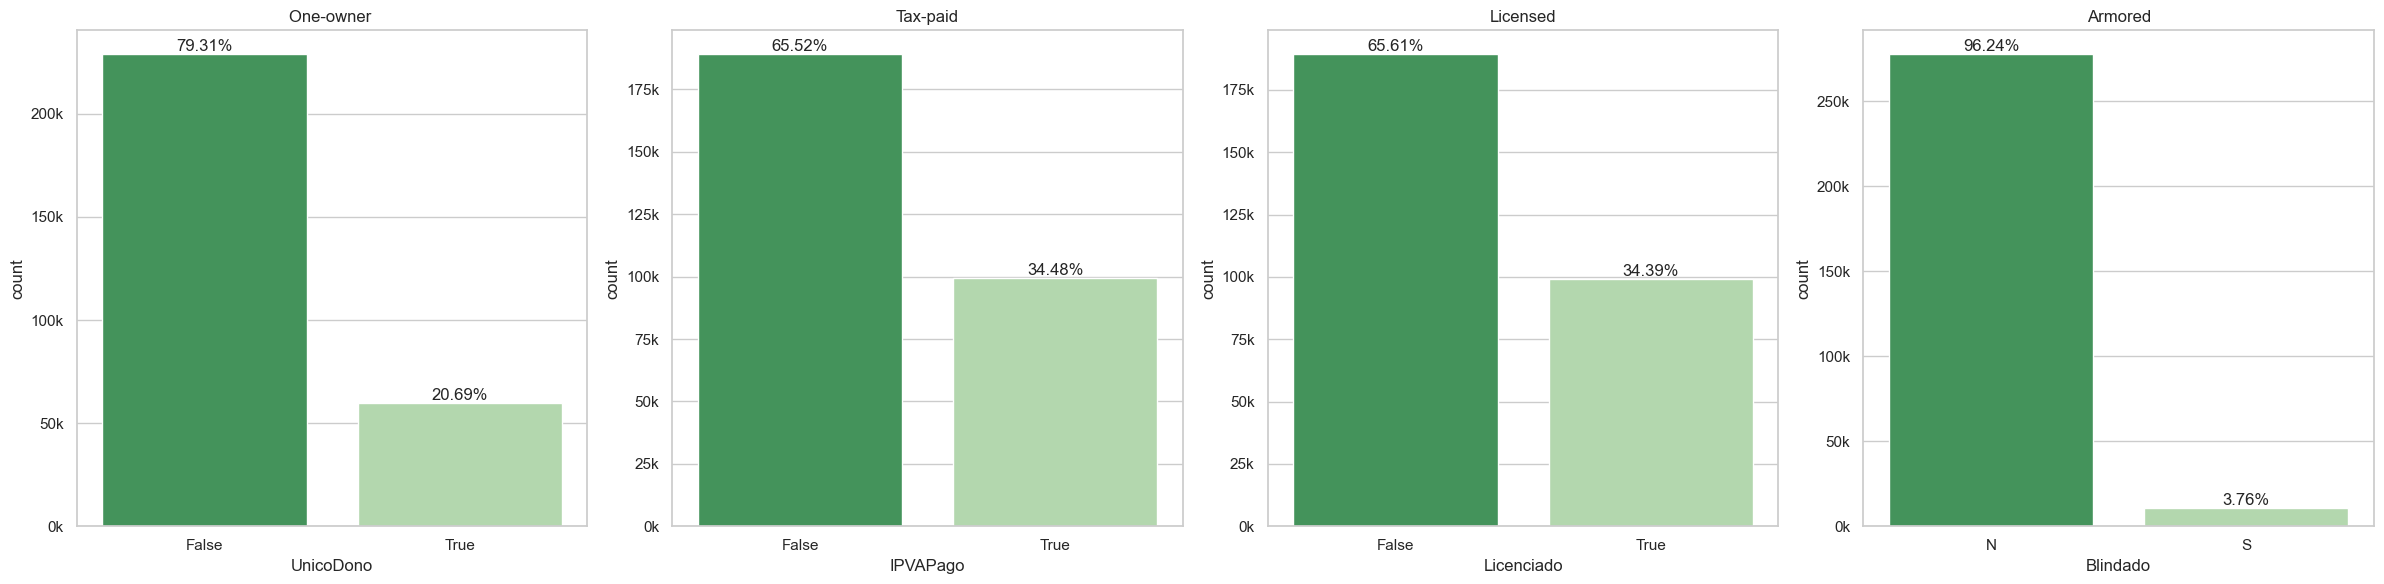

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_count_percentage(df1, 'UnicoDono', 'One-owner ', axs[0], 2, 12)
plot_count_percentage(df1, 'IPVAPago', 'Tax-paid', axs[1], 2, 12)
plot_count_percentage(df1, 'Licenciado', 'Licensed', axs[2], 2, 12)
plot_count_percentage(df1, 'Blindado', 'Armored', axs[3], 2, 12)
plt.tight_layout()
plt.show()

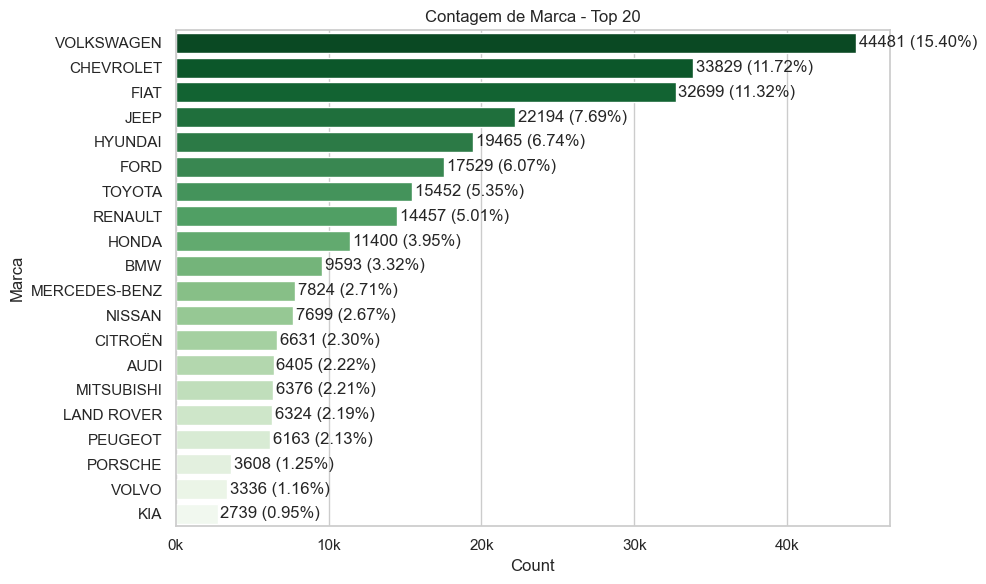

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df1, 'Marca', 'Contagem de Marca - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

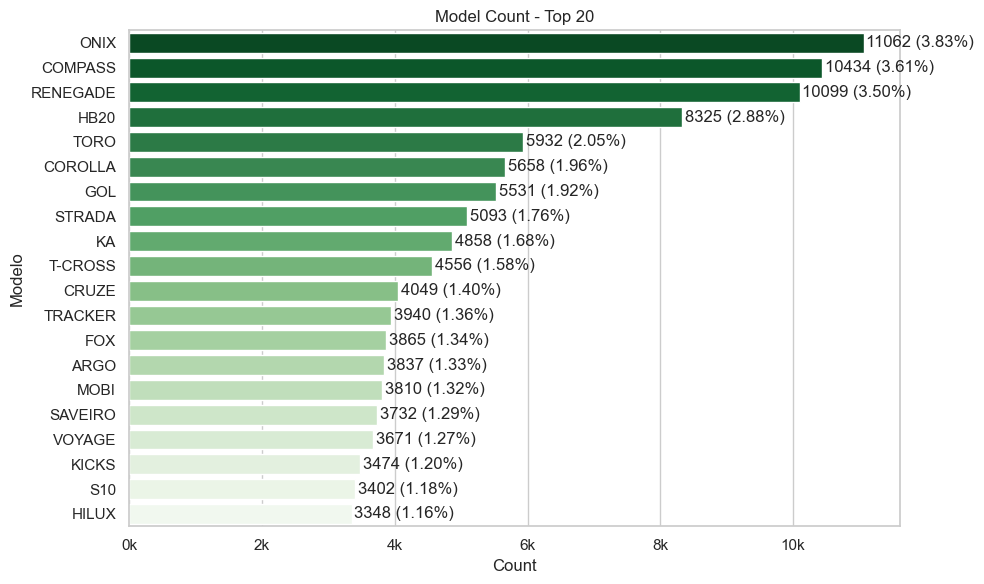

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df1, 'Modelo', 'Model Count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

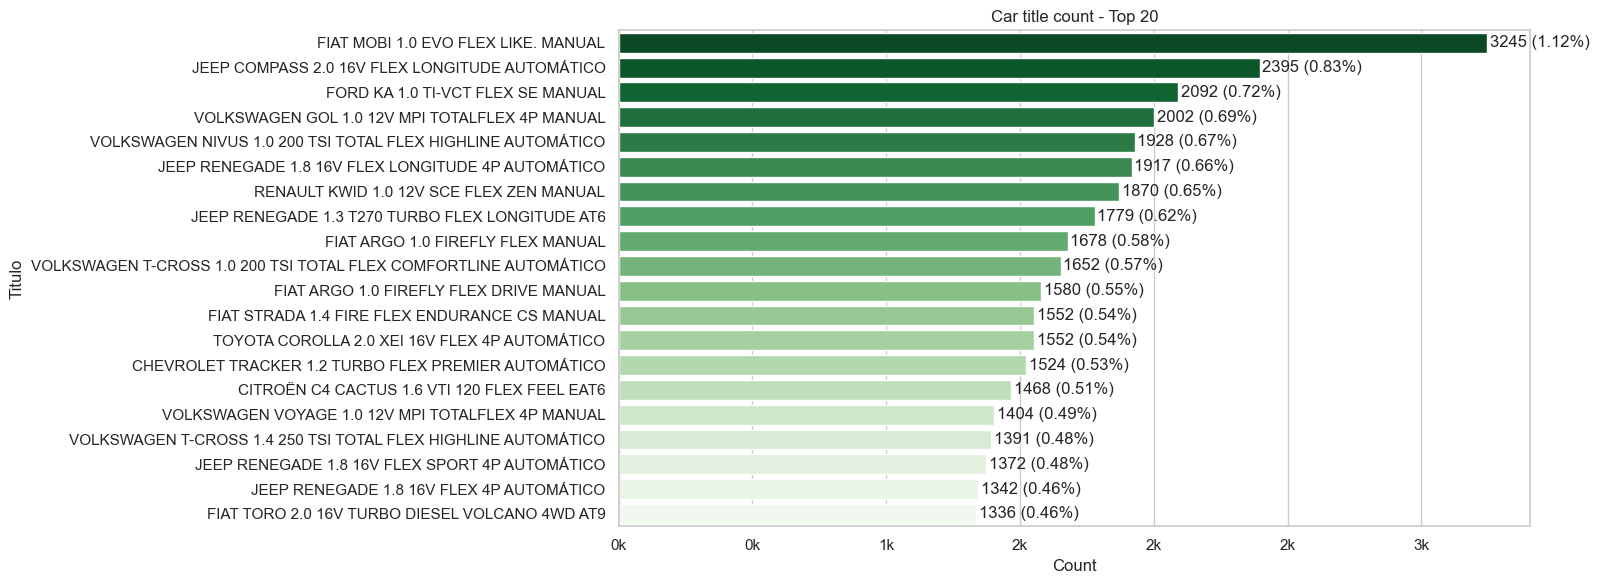

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_count_percentage_horizontal(df1, 'Titulo', 'Car title count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

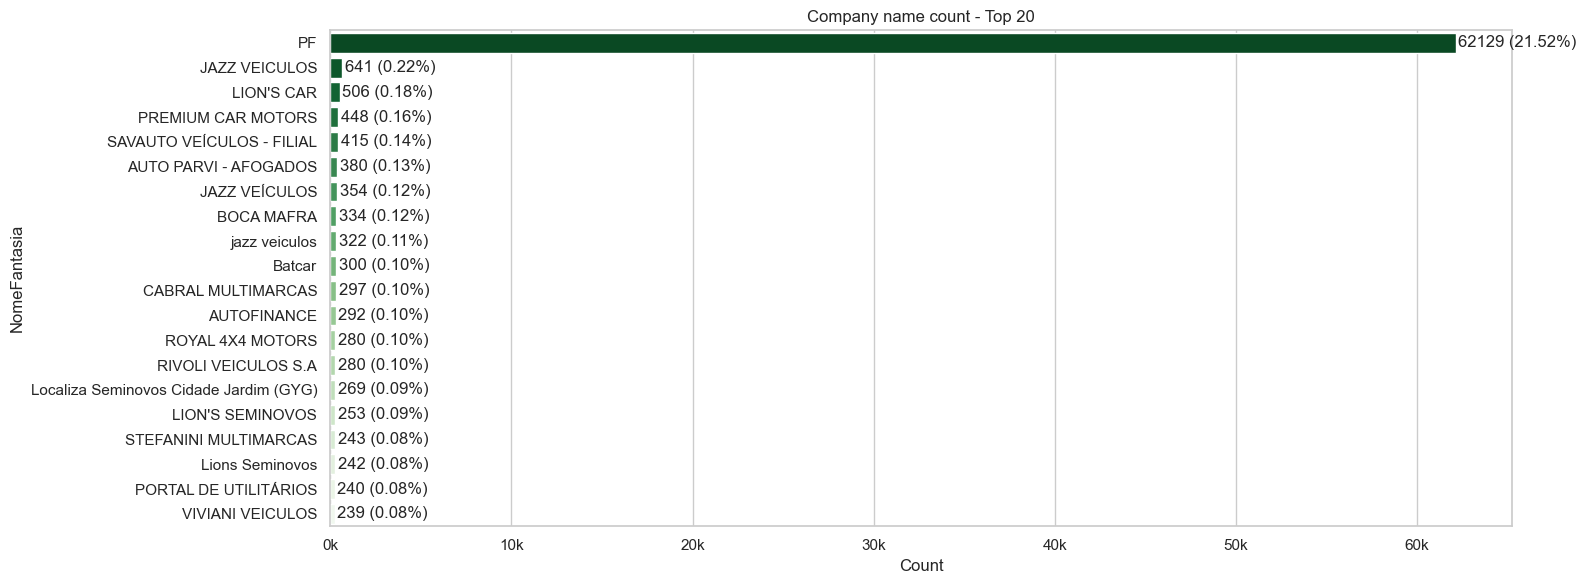

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_count_percentage_horizontal(df1, 'NomeFantasia', 'Company name count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

# 2.0 - Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 - Creating hypotesis

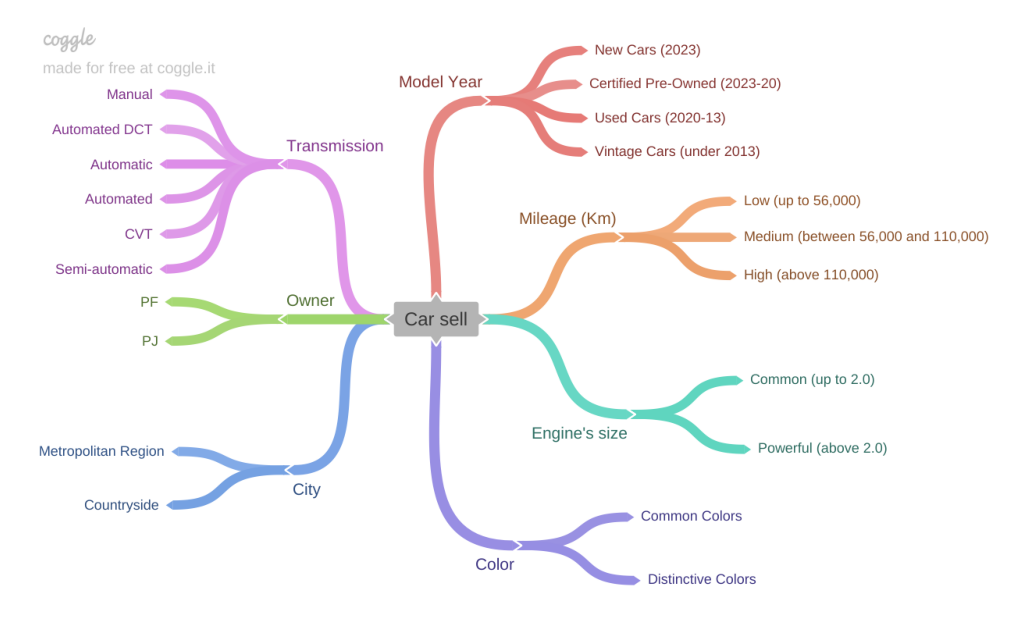

In [26]:
path_to_image = R'C:\Users\gfurt\OneDrive\Documentos\Gabriel\Car_sell_mental_map.png'
from PIL import Image

image = Image.open(path_to_image)
plt.figure(figsize=(16, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

**Hypotesis**

- **H1 - Model Year:** Cars lose 10% of their value for each of the first 10 years of use.
- **H2 - Mileage (KM):** Cars with lower mileage are more expensive than those with higher mileage
- **H3 - Color_2:** Cars in common colors are more expensive than cars in other colors
- **H4 - City:** There are more cars for sale in the top 5 metropolitan cities
- **H5 - Owner:** Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF)   

## 2.2. Feature Engineering

### 2.2.1. Valor Fipe

In [27]:
# Creating the feature with the car model's value in the FIPE table
df2['Valor Fipe'] = df2['Valor'] / df2['Fipe'] * 100

### 2.2.2. Combustivel

In [28]:
hibrido = df2['Versao'].str.contains(r'HIBRIDO|HYBRID|HEV|PHEV|MHEV|HÍBRIDO', case=False)
df2.loc[hibrido, 'Combustivel'] = 'Hibrido'

eletrico = df2['Versao'].str.contains(r'ELETRICO|ELECTRIC|ELÉTRICO', case=False)
df2.loc[eletrico, 'Combustivel'] = 'Eletrico'

diesel = df2['Versao'].str.contains(r'DIESEL', case=False)
df2.loc[diesel, 'Combustivel'] = 'Diesel'

alcool = df2['Versao'].str.contains(r'ÁLCOOL', case=False)
df2.loc[alcool, 'Combustivel'] = 'Alcool'

flex = df2['Versao'].str.contains(r'FLEX', case=False)
df2.loc[flex, 'Combustivel'] = 'Flex'

gasolina = df2['Versao'].str.contains(r'GASOLINA', case=False)
df2.loc[gasolina, 'Combustivel'] = 'Gasolina'

tetrafuel = df2['Versao'].str.contains(r'TETRAFUEL', case=False)
df2.loc[tetrafuel, 'Combustivel'] = 'Tetrafuel'

### 2.2.3. Cilindrada

In [29]:
# Create a new feature with the engine displacement described in the vehicle version
regex_exp = r'(\d+\.\d+)'
df2['Cilindrada'] = df2['Versao'].str.extract(regex_exp)

In [30]:
# Assign '0' for electric cars
condicao = (df2['Cilindrada'].isna()) | (df2['Cilindrada'] == '')
df2.loc[condicao & eletrico, 'Cilindrada'] = 0

df2['Cilindrada'] = df2['Cilindrada'].astype('float64')

### 2.2.4. Segmenting the cars by year

In [31]:
# Criar um nome para identificar cada versão e ano de cada carro
df2['Marca - Modelo - Versao - Ano'] = df2.apply(lambda row: ' - '.join(map(str, [row['Titulo'], row['AnoModelo']])), axis=1)

# 3.0 - Variable Filtering

In [32]:
df3 = df2.copy()

## 3.1. Row Filtering

### 3.1.1 Filtering missing values 

In [33]:
# Identifying missing values
df3.isna().sum()

UniqueId                            0
Titulo                              0
Marca                               0
Modelo                              0
Versao                              0
AnoFabricacao                       0
AnoModelo                           0
Cidade                              0
Estado                              0
KM                                  0
Cambio                              0
NumeroPortas                        0
TipoCorpo                           8
UnicoDono                           0
IPVAPago                            0
Licenciado                          0
Blindado                            0
Cor                                 0
TipoVendedor                        0
TipoAnuncio                         0
NomeFantasia                        0
Fipe                                0
Link                                0
Valor                               0
Valor Fipe                          0
Combustivel                      3592
Cilindrada  

In [34]:
# Removing rows with missing values in the 'Cilindrada' column
df3 = df3.copy()
df3.dropna(subset=['Cilindrada'], inplace=True)

In [35]:
# Removing rows with missing values in the 'Combustivel' column
df3 = df3.copy()
df3.dropna(subset=['Combustivel'], inplace=True)

### 3.1.2 Filtering outliers in KM

In [36]:
# Removendo KM acima de 888.888 e nos casos abaixo de 300 KM manter somente os carros de 2023, visto que muitos anúncios são realizados com erros na KM

df3 = df3[df3['KM'] < 888888]

df3 = df3[df3['KM'] != 0]

condition_km = df3['KM'] <= 300
condition_ano = df3['AnoModelo'] < 2023
df3 = df3[~(condition_km & condition_ano)]

### 3.1.3 Filtering only newer cars

In [37]:
# Filtrando apenas os carros dos últimos 15 anos
df3 = df3[df3['AnoModelo'] >= 2010]

### 3.1.4 Filtering duplicate IDs

In [38]:
# Remover todos os anúncios duplicados (provavelmente apareceram mais de uma vez no momento da coleta dos dados devido a anúncio pago pela parte do vendedor)
df3 = df3.drop_duplicates(subset=['UniqueId'], keep='first')

### 3.1.5 Filtering Fipe error

In [39]:
df3 = df3[df3['Fipe'] != 666]

### 3.1.6 Filtering Value outliers

In [40]:
# Remover outliers através do cálculo do Intervalo Interquartil (IQR) com um fator multiplicativo de 5 no atributo 'Fipe'.
# Seguido por um ajuste adicional para registros com uma variação de valor em relação à mediana abaixo de 30%.
df3_outlier = df3.copy()

# Separa os registros com apenas 1 anúncio por versão-ano
ocorrencias_por_valor = df3_outlier['Marca - Modelo - Versao - Ano'].value_counts()
versoes_unicas = ocorrencias_por_valor[ocorrencias_por_valor == 1].index
df_versoes_unicas = df3_outlier[df3_outlier['Marca - Modelo - Versao - Ano'].isin(versoes_unicas)]
df3_outlier = df3_outlier[~df3_outlier['Marca - Modelo - Versao - Ano'].isin(versoes_unicas)]

# Criar uma nova coluna 'Outlier'
df3_outlier['Outlier'] = df3_outlier['Fipe'].transform(identificar_outliers)

# Identificar classificações de outlier erradas através do valor
df3_outlier_aux = df3_outlier[df3_outlier['Outlier'] == True]

# Levantar todos os carros identificados como outliers
outliers = df3_outlier_aux['Marca - Modelo - Versao - Ano'].unique()
df3_outlier_true = df3_outlier[df3_outlier['Marca - Modelo - Versao - Ano'].isin(outliers)]

# Calcular a mediana para esses carros identificados
df3_outliers_median = df3_outlier_true[['Marca - Modelo - Versao - Ano', 'Valor']].groupby('Marca - Modelo - Versao - Ano').median().reset_index()
df3_outliers_median = df3_outliers_median.rename(columns={'Valor': 'Mediana'})

# Comparar o valor dos outliers com a mediana
df3_outlier_aux = df3_outlier_aux.merge(df3_outliers_median, on='Marca - Modelo - Versao - Ano', how='left')
df3_outlier_aux['variacao'] = round(abs((df3_outlier_aux['Valor'] / df3_outlier_aux['Mediana']) - 1), 2)

# Identificar os casos com variação abaixo de 30%
df_aux = df3_outlier_aux[df3_outlier_aux['variacao'] < 0.3]
ajuste_outliers = df_aux['UniqueId'].unique()

# Alterar o status de outliers para False nos casos identificados
df3_outlier.loc[df3_outlier['UniqueId'].isin(ajuste_outliers), 'Outlier'] = False

# Identificar casos em que todos os carros foram registrados como outlier
somente_outliers = df3_outlier.groupby('Marca - Modelo - Versao - Ano')['Outlier'].all()
carros_somente_outliers = somente_outliers[somente_outliers].index

# Alterar o status de outliers para False nos casos identificados
df3_outlier.loc[df3_outlier['Marca - Modelo - Versao - Ano'].isin(carros_somente_outliers), 'Outlier'] = False

n_outliers = df3_outlier[df3_outlier['Outlier'] == True].shape[0]
print(f'Outliers identificados: {n_outliers}')

# Adiciona de volta os carros com apenas 1 registro
df_versoes_unicas['Outlier'] = False
df3_outlier = pd.concat([df3_outlier, df_versoes_unicas])

# Salva os outliers para conferência
df3_outlier_true = df3_outlier[df3_outlier['Outlier'] == True]

# Filtra somente os dados não outliers
df3_outlier_false = df3_outlier[df3_outlier['Outlier'] == False]

# Identificar os casos com variação abaixo de 30%
correct_ids = df3_outlier_false['UniqueId'].unique()

# Alterar o status de outliers para False nos casos identificados
df3 = df3[df3['UniqueId'].isin(correct_ids)]

Outliers identificados: 724


### 3.1.7 Filtering luxury cars

In [41]:
# Retira os carros de luxo (1% mais caros)
luxury_cars = df3[df3['Valor'] > 720000]
high_values_models = luxury_cars['Marca - Modelo - Versao - Ano'].unique()
df3 = df3[~df3['Marca - Modelo - Versao - Ano'].isin(high_values_models)]

### 3.1.8 Filtering Brands

In [42]:
# Remover Marcas com menos de 1% do dataset
df_aux = df3['Marca'].value_counts(normalize = True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_marcas = df_aux['Marca']
df3 = df3[df3['Marca'].isin(top_marcas)]

## 3.2. Feature Filtering

In [43]:
# Removing 'Fipe' feature - to prevent data leakage (since this feature displays the percentage that the car's value represents of the FIPE table)
# FIPE tableis a well-known reference used for pricing vehicles

df3 = df3.drop('Fipe', axis=1)

In [44]:
# Removing 'Valor Fipe' Feature
df3 = df3.drop('Valor Fipe', axis=1)

# Study the possibility of including this feature in the next version of the model, since the values from the FIPE table are available on the internet.
# The idea would be to include a step to query the value in the FIPE table before making the value prediction.

In [45]:
# Removing 'Link' Feature
df3 = df3.drop('Link', axis=1)

In [46]:
# Removing 'Titulo' Feature
df3 = df3.drop('Titulo', axis=1)

In [47]:
# Removing 'Marca - Modelo - Versao - Ano' Feature
df3 = df3.drop('Marca - Modelo - Versao - Ano', axis=1)

In [48]:
# Removing 'NomeFantasia' Feature
df3 = df3.drop('NomeFantasia', axis=1)

# 4.0 - Exploratory Data Analysis

In [49]:
df4 = df3.copy()

In [50]:
column_names = ['Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'AnoModelo', 'Estado', 'Cidade', 'KM', 'Cambio', 'NumeroPortas', 'TipoCorpo', 
                'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor','TipoAnuncio', 'Combustivel', 'Cilindrada', 'Valor']

df4 = df4[column_names]

## 4.1 - Univaraite Analysis

In [51]:
num_attributes2 = df4.select_dtypes(include = ['int', 'float'])
cat_attributes2 = df4.select_dtypes(exclude = ['int', 'float', 'datetime'])

In [52]:
df4.dtypes

Marca             object
Modelo            object
Versao            object
AnoFabricacao      int64
AnoModelo          int64
Estado            object
Cidade            object
KM               float64
Cambio            object
NumeroPortas       int64
TipoCorpo         object
UnicoDono           bool
IPVAPago            bool
Licenciado          bool
Blindado          object
Cor               object
TipoVendedor      object
TipoAnuncio       object
Combustivel       object
Cilindrada       float64
Valor            float64
dtype: object

### 4.1.1. Numeric Attributes

In [53]:
descriptive_statistics(num_attributes2)

,attributes,range,media,mediana,std,skew,kurtosis,min,25%,50%,75%,90%,99%,max
0,AnoFabricacao,15.00,"2,017.97","2,019.00",3.47,-0.61,-0.61,"2,009.00","2,015.00","2,019.00","2,021.00","2,022.00","2,023.00","2,024.00"
1,AnoModelo,14.00,"2,018.57","2,019.00",3.49,-0.57,-0.66,"2,010.00","2,016.00","2,019.00","2,022.00","2,023.00","2,023.00","2,024.00"
2,KM,"888,700.00","73,693.33","64,624.00","47,627.71",1.82,10.98,100.00,"41,811.00","64,624.00","98,000.00","134,401.80","220,000.00","888,800.00"
3,NumeroPortas,4.00,3.78,4.00,0.77,-3.79,13.99,0.00,4.00,4.00,4.00,4.00,4.00,4.00
4,Cilindrada,6.30,1.65,1.60,0.60,1.62,6.69,0.00,1.20,1.60,2.00,2.30,3.30,6.30
5,Valor,"706,500.00","104,572.27","82,990.00","75,066.82",2.76,10.81,"13,500.00","58,900.00","82,990.00","122,900.00","185,000.00","429,000.00","720,000.00"


Text(0.5, 1.0, 'Valor')

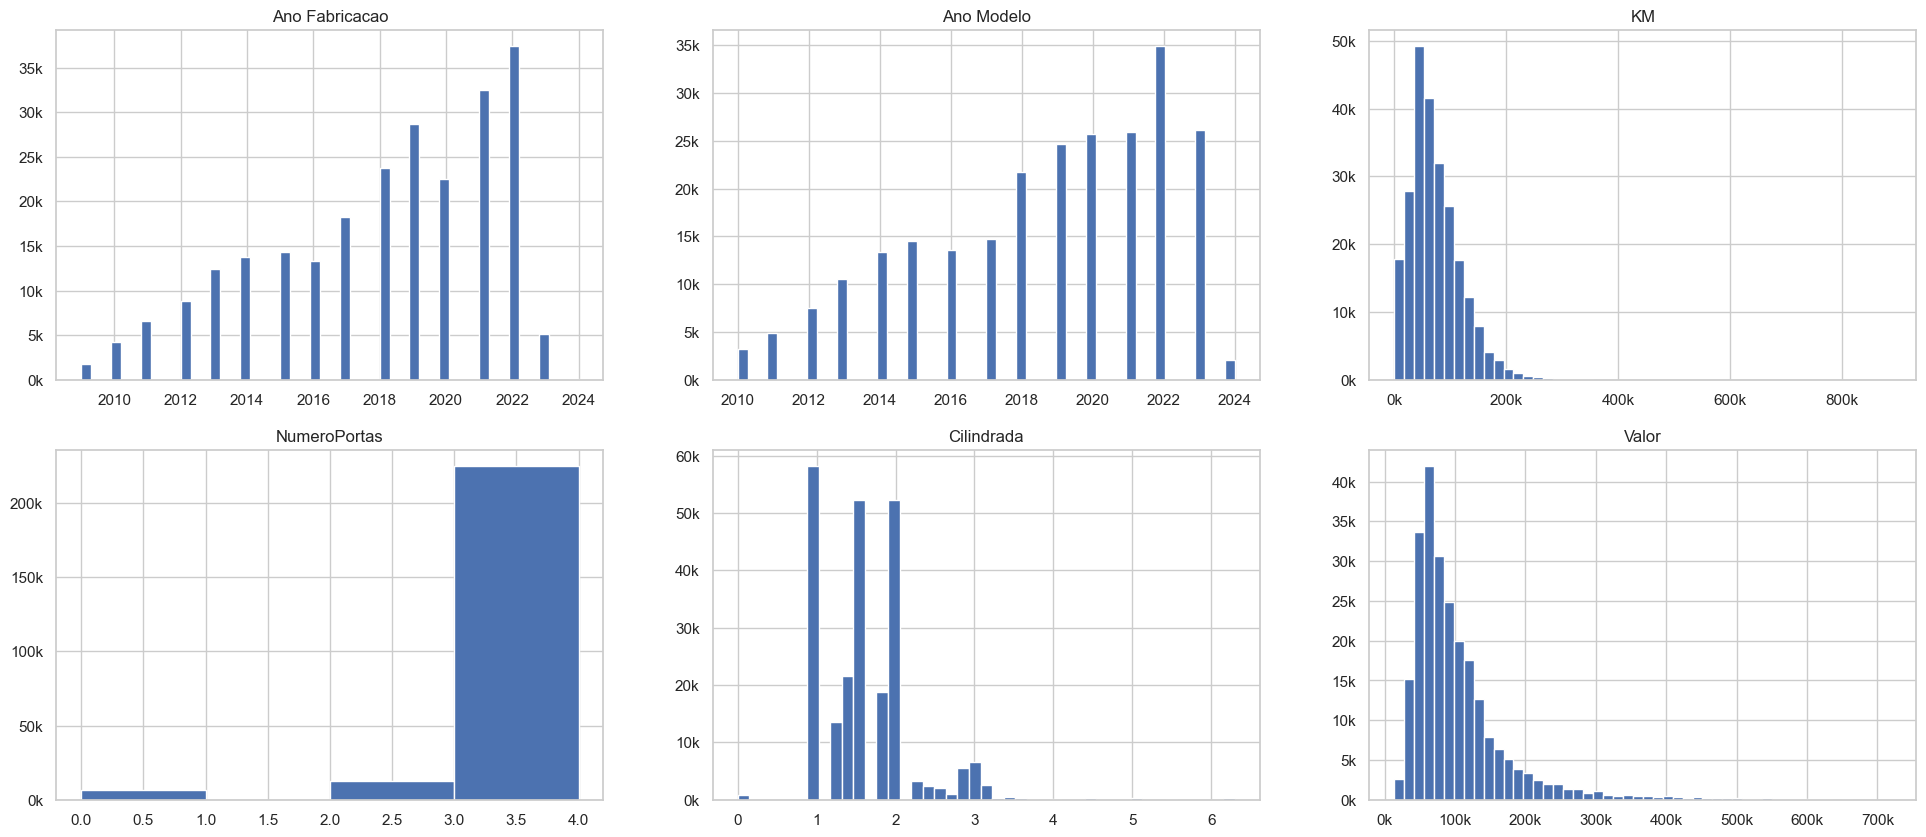

In [54]:
plt.subplot(2, 3, 1)
df4['AnoFabricacao'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Fabricacao")

plt.subplot(2, 3, 2)
df4['AnoModelo'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Ano Modelo")

plt.subplot(2, 3, 3)
df4['KM'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("KM")

plt.subplot(2, 3, 4)
df4['NumeroPortas'].hist(bins=len(df4['NumeroPortas'].unique()) , figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("NumeroPortas")

plt.subplot(2, 3, 5)
df4['Cilindrada'].hist(bins= len(df4['Cilindrada'].unique()), figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Cilindrada")

plt.subplot(2, 3, 6)
df4['Valor'].hist(bins= 50, figsize=(24,10))
plt.ticklabel_format(style = 'plain')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhares_x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(milhares_y))
plt.title("Valor")

### 4.1.2. Categorical Attributes

In [55]:
cat_attributes2.describe().T

,count,unique,top,freq
Marca,243432,19,VOLKSWAGEN,36427
Modelo,243432,422,ONIX,10374
Versao,243432,3089,1.0 12V MPI TOTALFLEX 4P MANUAL,3332
Estado,243432,27,São Paulo (SP),104537
Cidade,243432,1559,São Paulo,37009
Cambio,243432,7,Automática,140574
TipoCorpo,243430,9,Utilitário esportivo,89245
UnicoDono,243432,2,False,191686
IPVAPago,243432,2,False,160995
Licenciado,243432,2,False,162065


In [56]:
cat_attributes2.columns

Index(['Marca', 'Modelo', 'Versao', 'Estado', 'Cidade', 'Cambio', 'TipoCorpo',
       'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor',
       'TipoVendedor', 'TipoAnuncio', 'Combustivel'],
      dtype='object')

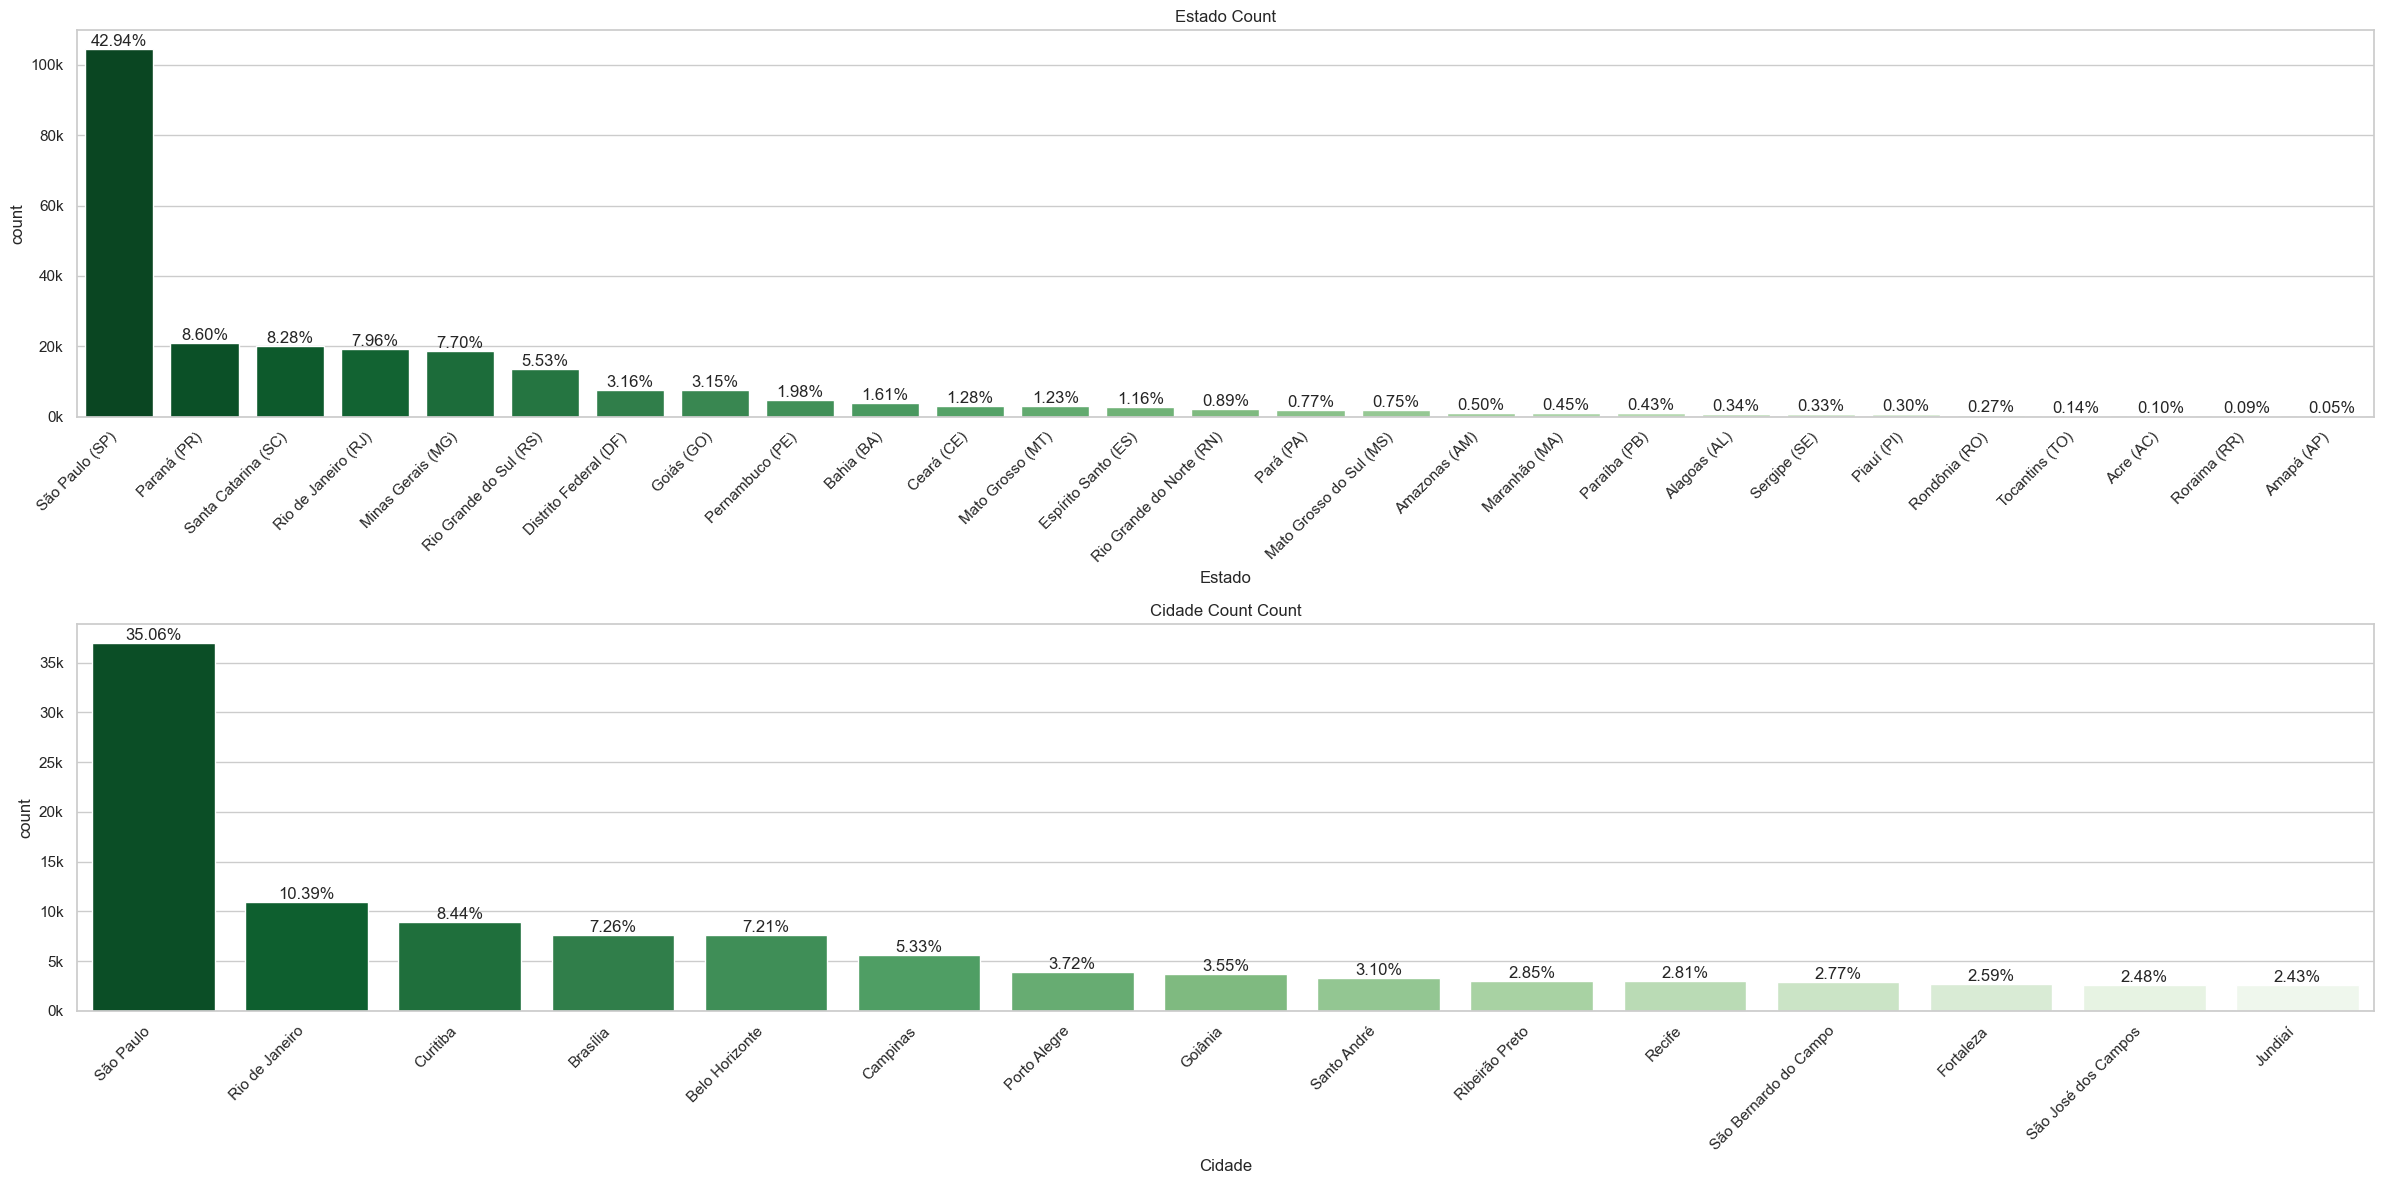

In [57]:
df_aux = df4['Cidade'].value_counts(normalize=True).reset_index()
df_aux = df_aux[df_aux['proportion'] >= 0.01]
top_cidades = df_aux['Cidade']
df_aux2 = df4[df4['Cidade'].isin(top_cidades)]

fig, axs = plt.subplots(2, 1, figsize=(24,12))

plot_count_percentage(df4, 'Estado', 'Estado Count', axs[0], 2, 12)
plot_count_percentage(df_aux2, 'Cidade', 'Cidade Count Count', axs[1], 2, 12)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

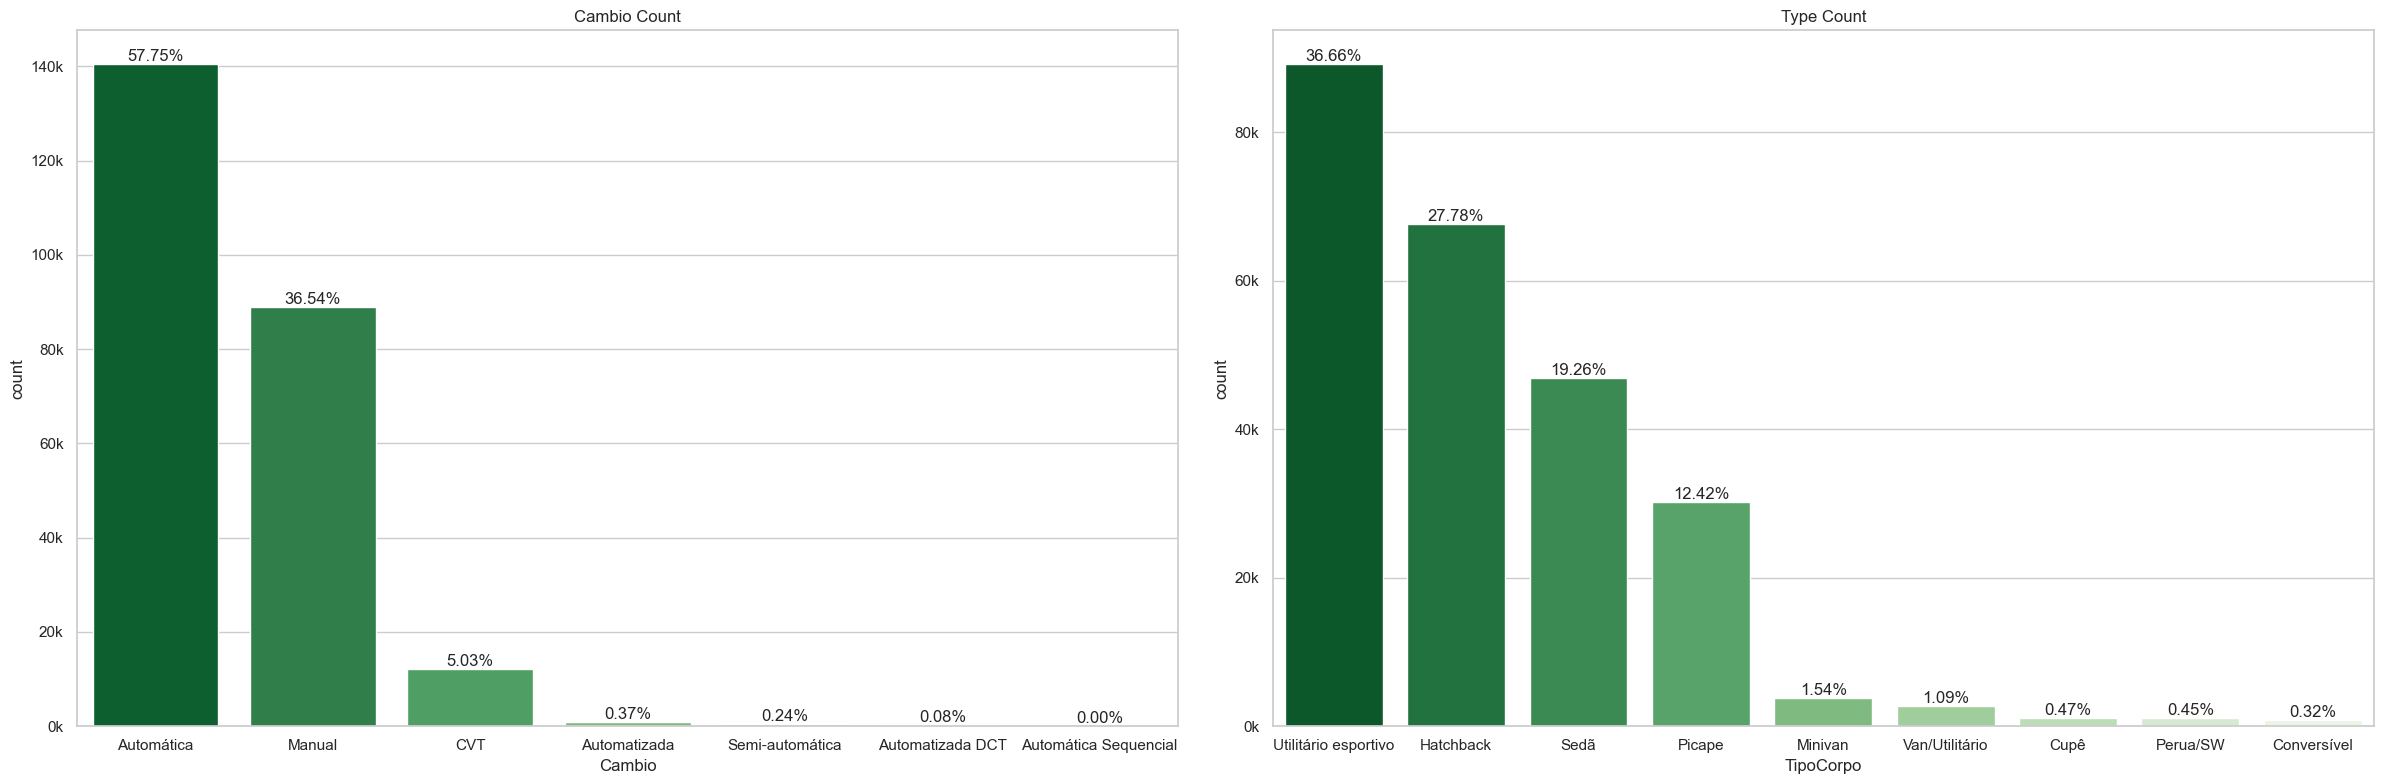

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

plot_count_percentage(df4, 'Cambio', 'Cambio Count', axs[0], 2, 12)
plot_count_percentage(df4, 'TipoCorpo', 'Type Count', axs[1], 2, 12)

plt.tight_layout()
plt.show()

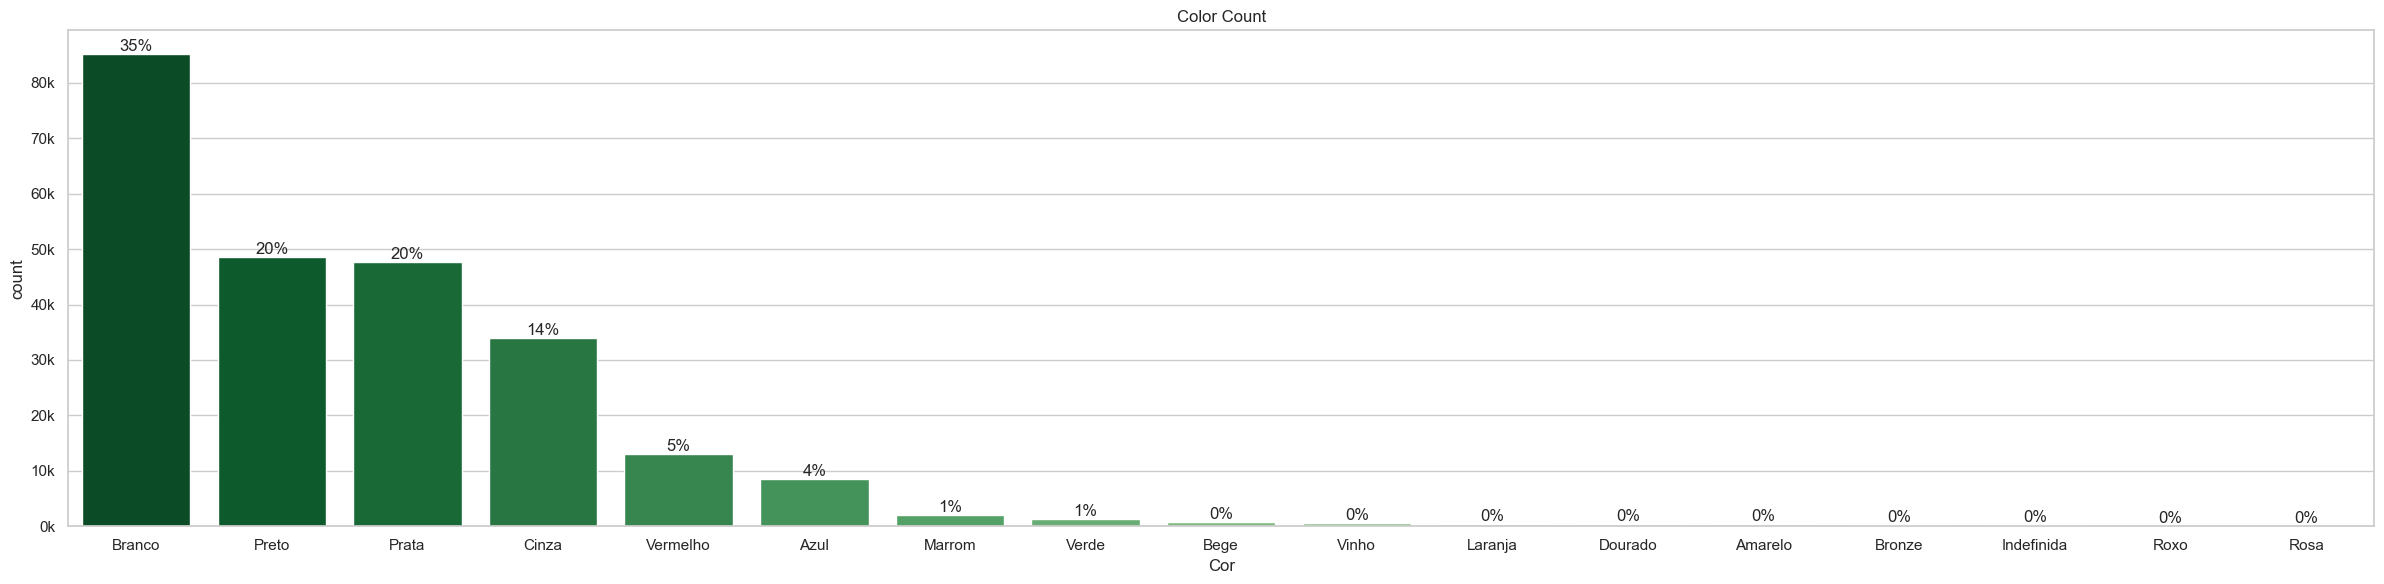

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df4, 'Cor', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

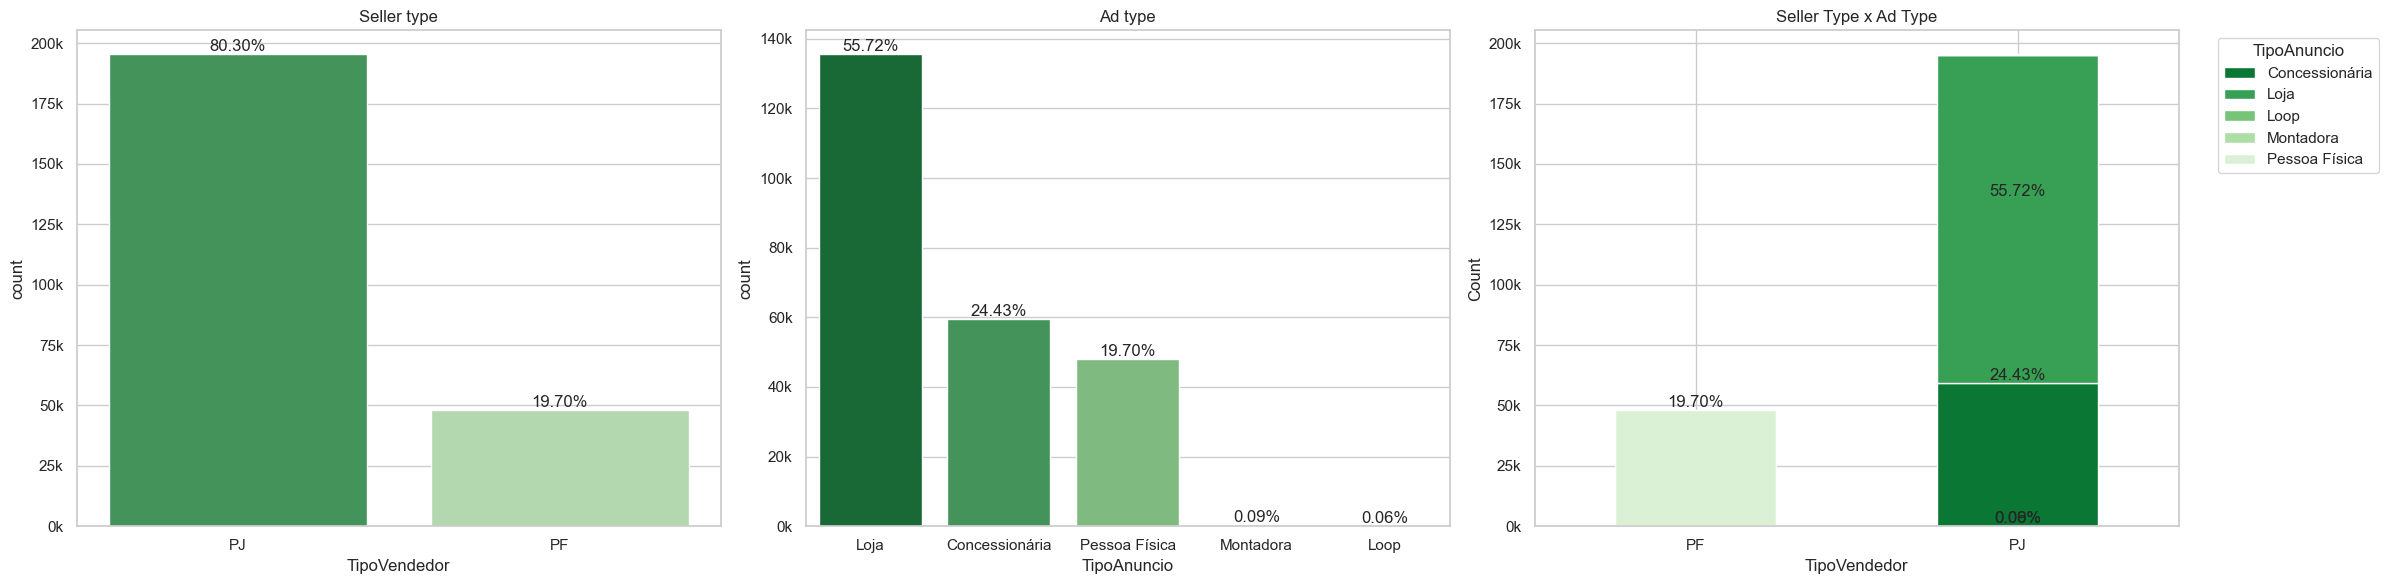

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

plot_count_percentage(df4, 'TipoVendedor', 'Seller type', axs[0], 2, 12)
plot_count_percentage(df4, 'TipoAnuncio', 'Ad type', axs[1], 2, 12)
plot_combined_bar_chart(df4, axs[2], 'Seller Type x Ad Type')

plt.tight_layout()
plt.show()

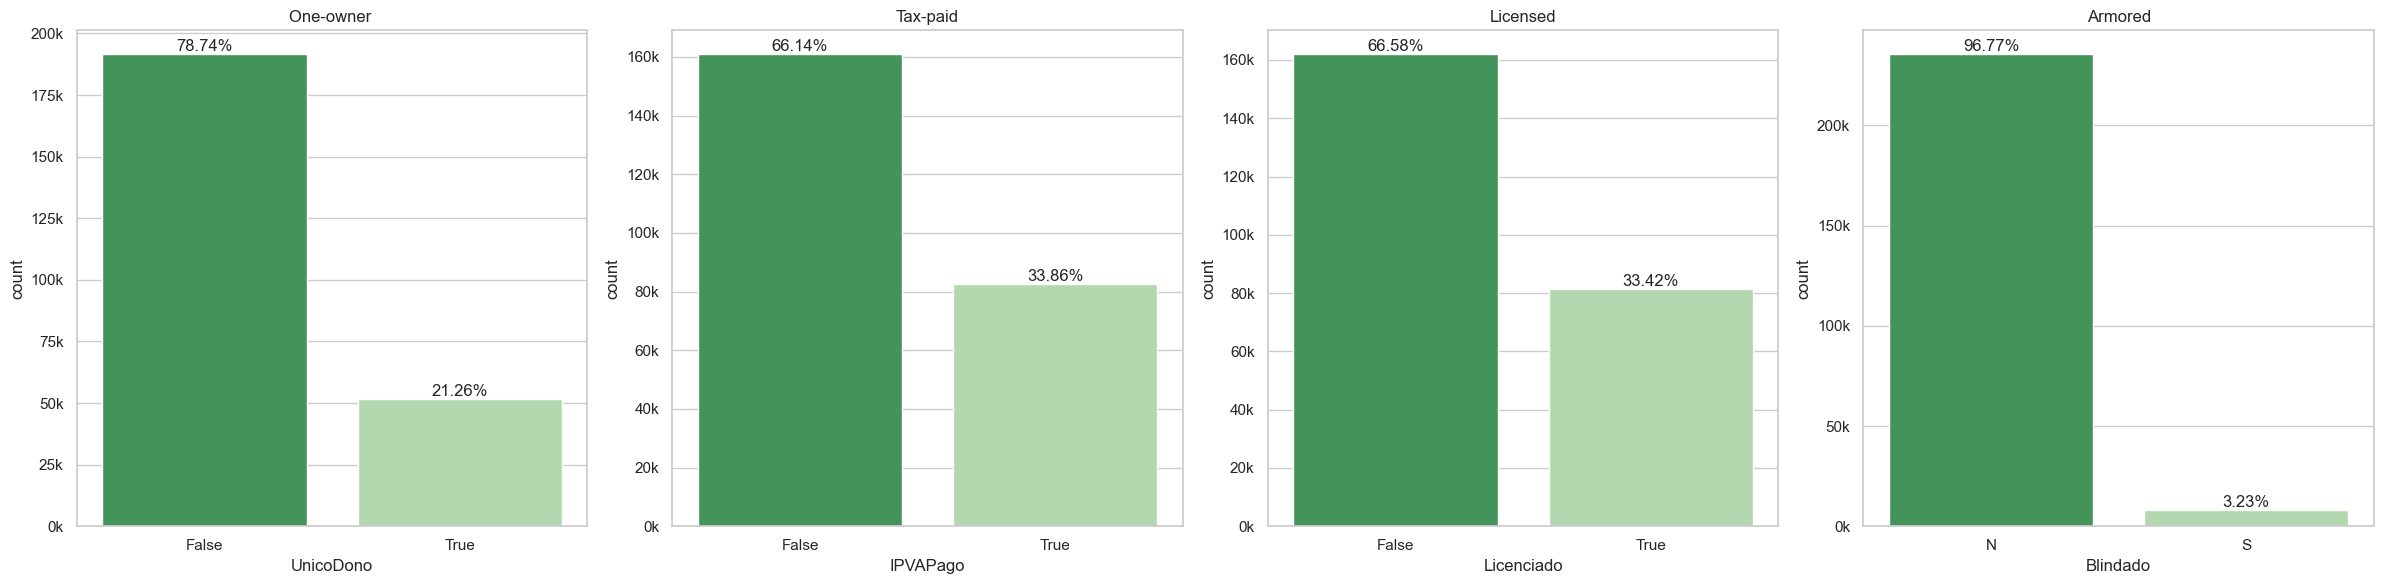

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_count_percentage(df4, 'UnicoDono', 'One-owner ', axs[0], 2, 12)
plot_count_percentage(df4, 'IPVAPago', 'Tax-paid', axs[1], 2, 12)
plot_count_percentage(df4, 'Licenciado', 'Licensed', axs[2], 2, 12)
plot_count_percentage(df4, 'Blindado', 'Armored', axs[3], 2, 12)
plt.tight_layout()
plt.show()

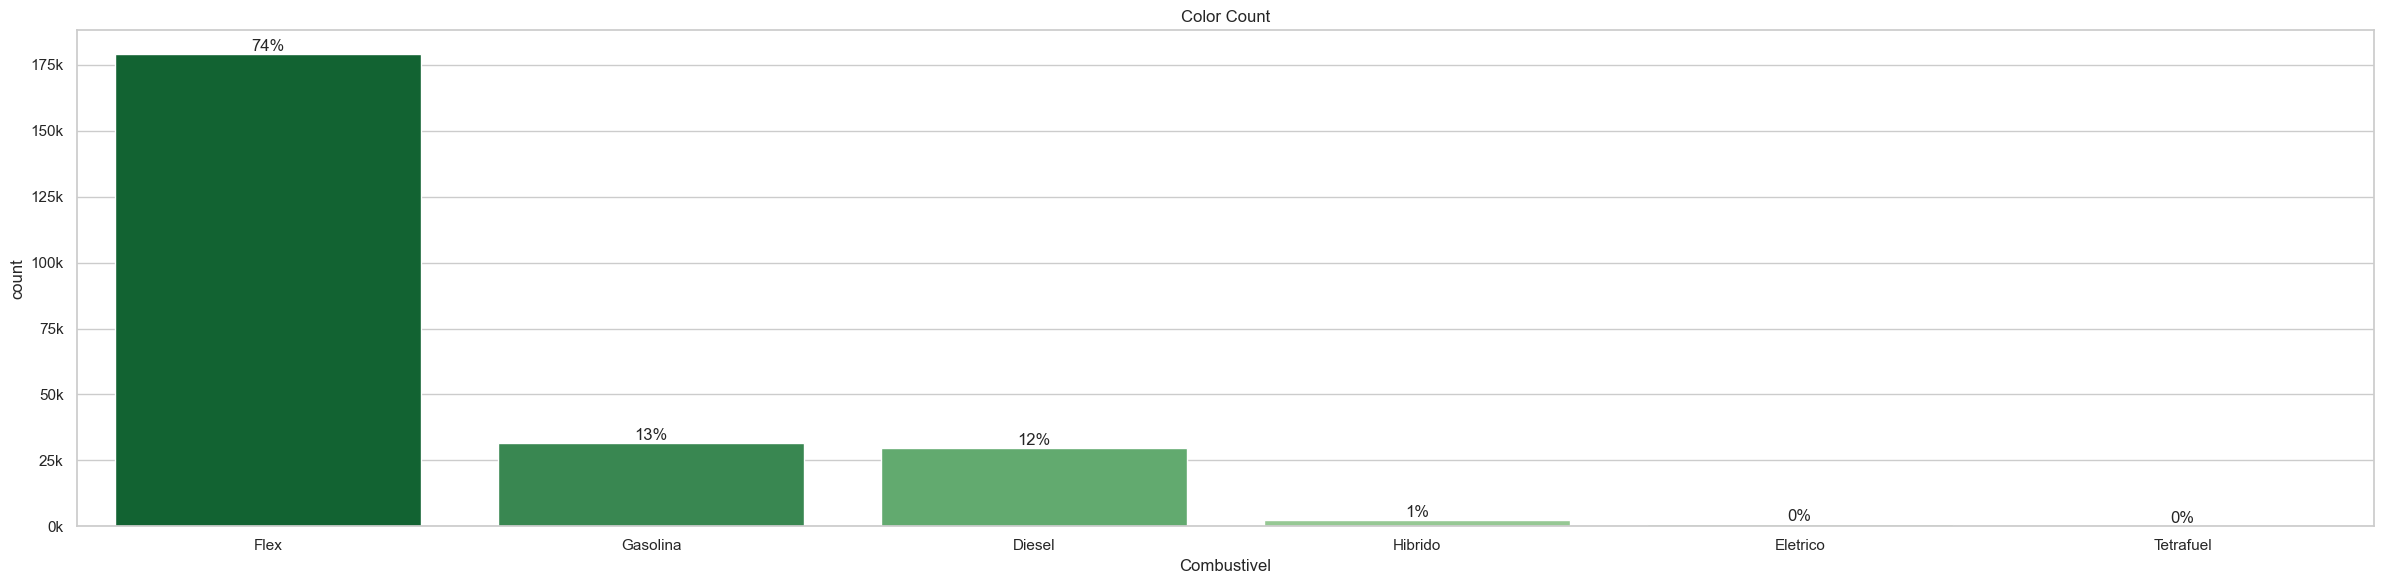

In [62]:
fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df4, 'Combustivel', 'Color Count', axs, 0, 12)

plt.tight_layout()
plt.show()

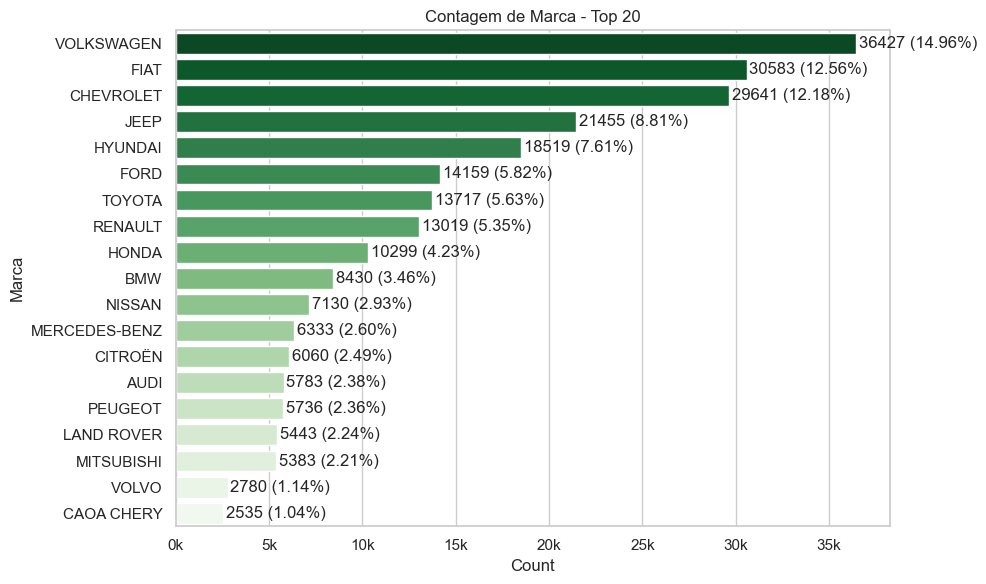

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df4, 'Marca', 'Contagem de Marca - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

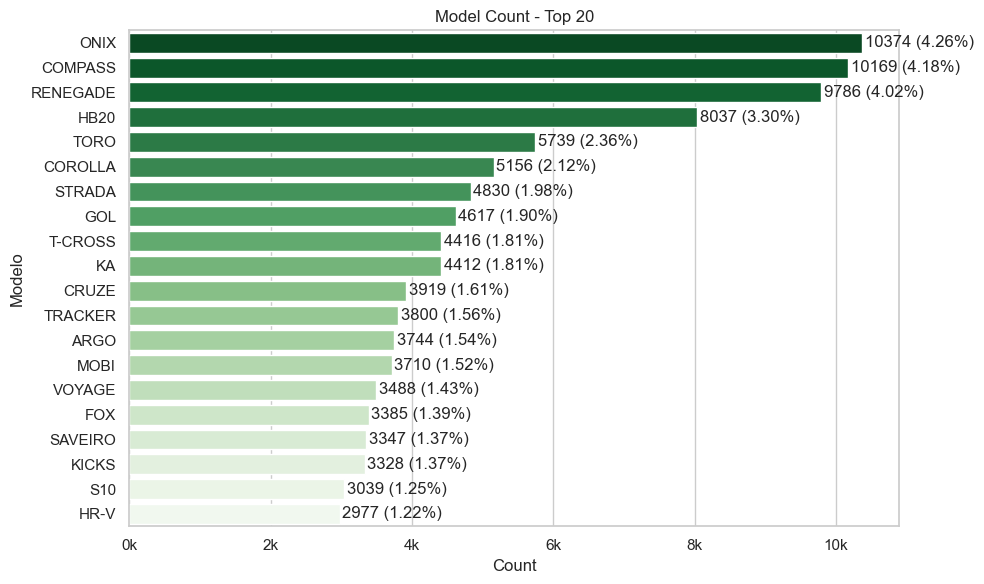

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_count_percentage_horizontal(df4, 'Modelo', 'Model Count - Top 20', ax, top_n=20)
plt.tight_layout()
plt.show()

## 4.2 - Bivaraite Analysis

**Hypotesis**

- **H1 - Model Year:** Cars lose 10% of their value for each of the first 10 years of use.
- **H2 - Mileage (KM):** Cars with lower mileage are more expensive than those with higher mileage
- **H3 - Color_2:** Cars in common colors are more expensive than cars in other colors
- **H4 - City:** There are more cars for sale in the top 5 metropolitan cities
- **H5 - Owner:** Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF)

### 4.2.1. H1 - Model Year: Cars lose 10% of their value for each of the first 10 years of use: <span style="color:Red">False</span>

In [65]:
df_aux = df4[df4['AnoModelo'] >= 2013]
df_mean_valor = df_aux.groupby(['Marca', 'Modelo', 'Versao', 'AnoModelo'])['Valor'].mean().reset_index()
df_mean_valor['Marca - Modelo - Versao'] = df_mean_valor.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao']])), axis=1)
df_mean_valor = df_mean_valor.sort_values(by=['Marca - Modelo - Versao', 'AnoModelo'], ascending=[True, False])
df_mean_valor['Diferenca_Ano_Modelo'] = df_mean_valor.groupby('Marca - Modelo - Versao')['AnoModelo'].transform(lambda x: x.diff())
df_mean_valor['Diferenca_Valor'] = df_mean_valor.groupby('Marca - Modelo - Versao')['Valor'].transform(lambda x: x.diff())
df_mean_valor['Variation'] = (((df_mean_valor['Valor'] / (df_mean_valor['Valor'] + df_mean_valor['Diferenca_Valor'])  ) ** (1/df_mean_valor['Diferenca_Ano_Modelo'])) -1 ) * 100

In [66]:
df_mean_valor_dropna = df_mean_valor.dropna(subset=['Variation']).copy()
df_aux = df_mean_valor_dropna.groupby('Marca - Modelo - Versao')['Variation'].mean().reset_index()
df_aux['Variation'].mean()

-8.11581884275674

#### The average annual depreciation is 8.03%, approximately 20% below the expected value

PS: According to the data collected from cars advertised on WebMotors

### 4.2.2. H2 - Cars with lower mileage are more expensive than those with higher mileage: <span style="color:green">True</span>

In [67]:
df_aux = df4.copy()
df_aux['Marca - Modelo - Versao - Ano'] = df_aux.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao'], row['AnoModelo']])), axis=1)
df_aux = df_aux[['Marca - Modelo - Versao - Ano', 'KM', 'Valor']]
df_aux = df_aux.sort_values(by=['Marca - Modelo - Versao - Ano', 'KM'], ascending=[True, False]).reset_index()
df_aux['Diferenca_Valor'] = df_aux.groupby('Marca - Modelo - Versao - Ano')['Valor'].transform(lambda x: x.diff())

df_aux.head()

,index,Marca - Modelo - Versao - Ano,KM,Valor,Diferenca_Valor
0,243966,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"151,000.00","59,990.00",NaN
1,233289,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"145,000.00","50,500.00","-9,490.00"
2,249057,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"140,267.00","53,890.00","3,390.00"
3,338614,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"140,000.00","58,000.00","4,110.00"
4,159640,AUDI - A1 - 1.4 TFSI ATTRACTION 16V 122CV GASO...,"134,431.00","59,900.00","1,900.00"


In [68]:
df_aux2 = df_aux.groupby(['Marca - Modelo - Versao - Ano'])['Diferenca_Valor'].mean().reset_index()
df_aux2['Diferenca_Valor_Pos'] = df_aux2['Diferenca_Valor'].apply(lambda x: 'Positiva' if x > 0 else 'Não Positiva')
pd.DataFrame(df_aux2['Diferenca_Valor_Pos'].value_counts(normalize=True)*100).reset_index()

,Diferenca_Valor_Pos,proportion
0,Positiva,61.71
1,Não Positiva,38.29


In [69]:
round(df_aux2['Diferenca_Valor'].mean(),2)

1181.66

#### 62% of the analyzed cars confirmed that the lower the mileage, the higher the car's value, while 38% recorded a lower price (contrary to the hypothesis). 

We can also identify a positive average variation of R\$1,189.05

indicating that the price difference between two cars of the same version and year is positive, by R$ 1,189.05, when compared to another with lower mileage.

Therefore, even though the relationship is not very strong, the hypothesis proves to be true.


PS: According to the data collected from cars advertised on WebMotors.

### 4.2.3. H3 - Color: Cars in common colors are more expensive than cars in other colors: <span style="color:Green">True</span>

Establishing that the most common car colors are black, white, and silver, we compare the total number of cars advertised in these colors against those in other colors.

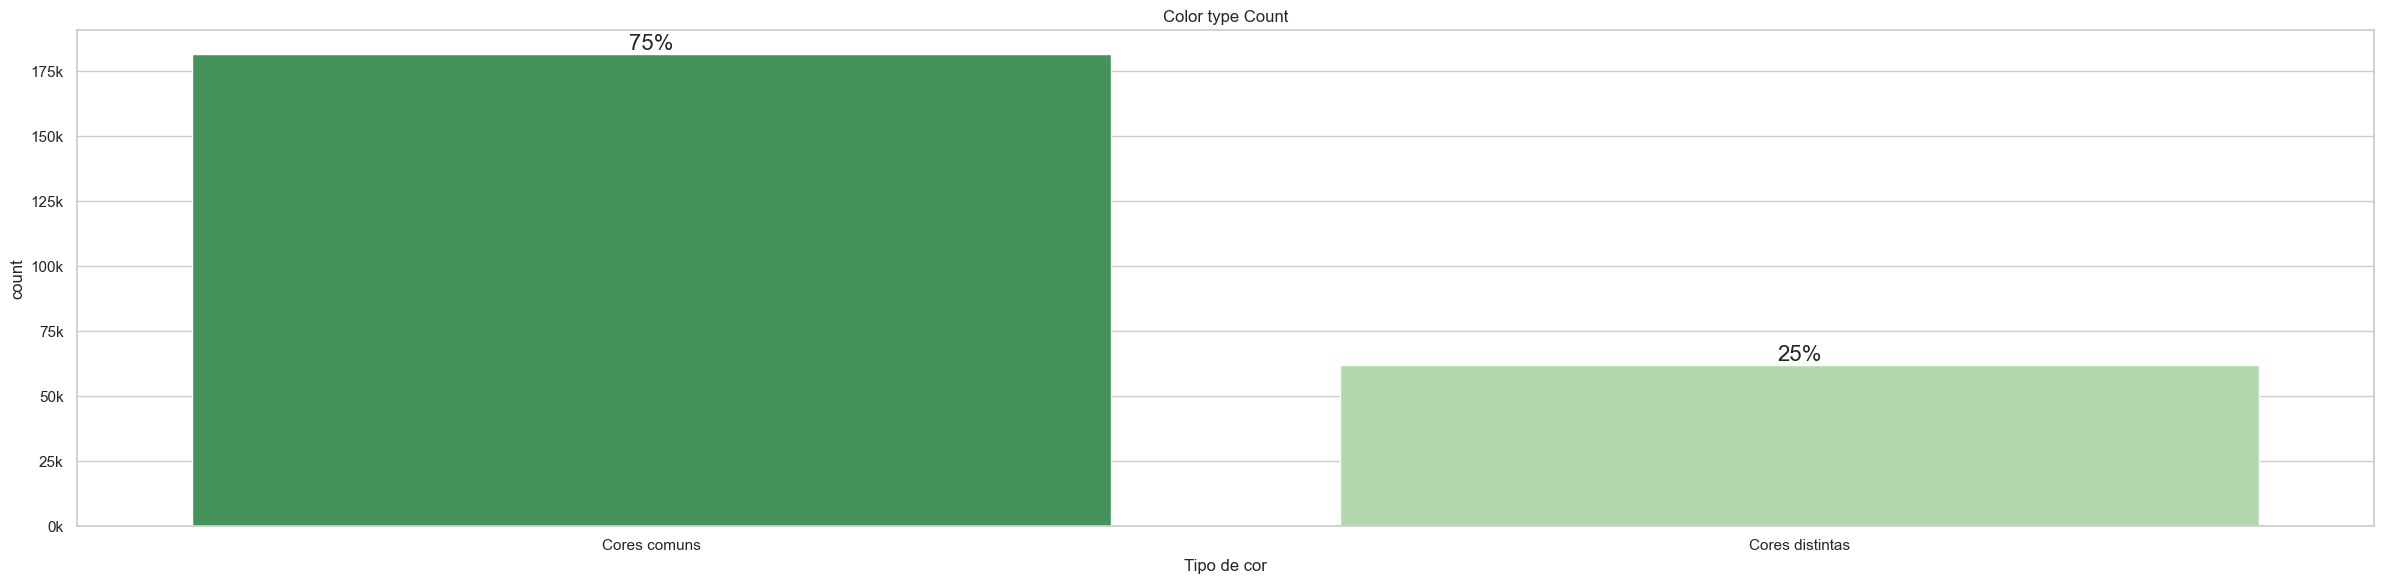

In [70]:
df_aux = df4.copy()

cores_comuns = ['Prata', 'Preto', 'Branco']
df_aux['Tipo de cor'] = df_aux['Cor'].apply(lambda x: 'Cores comuns' if x in cores_comuns else 'Cores distintas')

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df_aux, 'Tipo de cor', 'Color type Count', axs, 0, 16)

plt.tight_layout()
plt.show()

As shown, **75%** of the advertised cars are in the colors black, white, and silver, with only 25% in different colors.

### 4.2.4. H4 - City: There are more cars for sale in the top 5 metropolitan cities: <span style="color:Green">True</span>

Top 5 cidades metropolitanas do brasil:
- São Paulo
- Rio de Janeiro
- Belo Horizonte
- Porto Alegre
- Recife

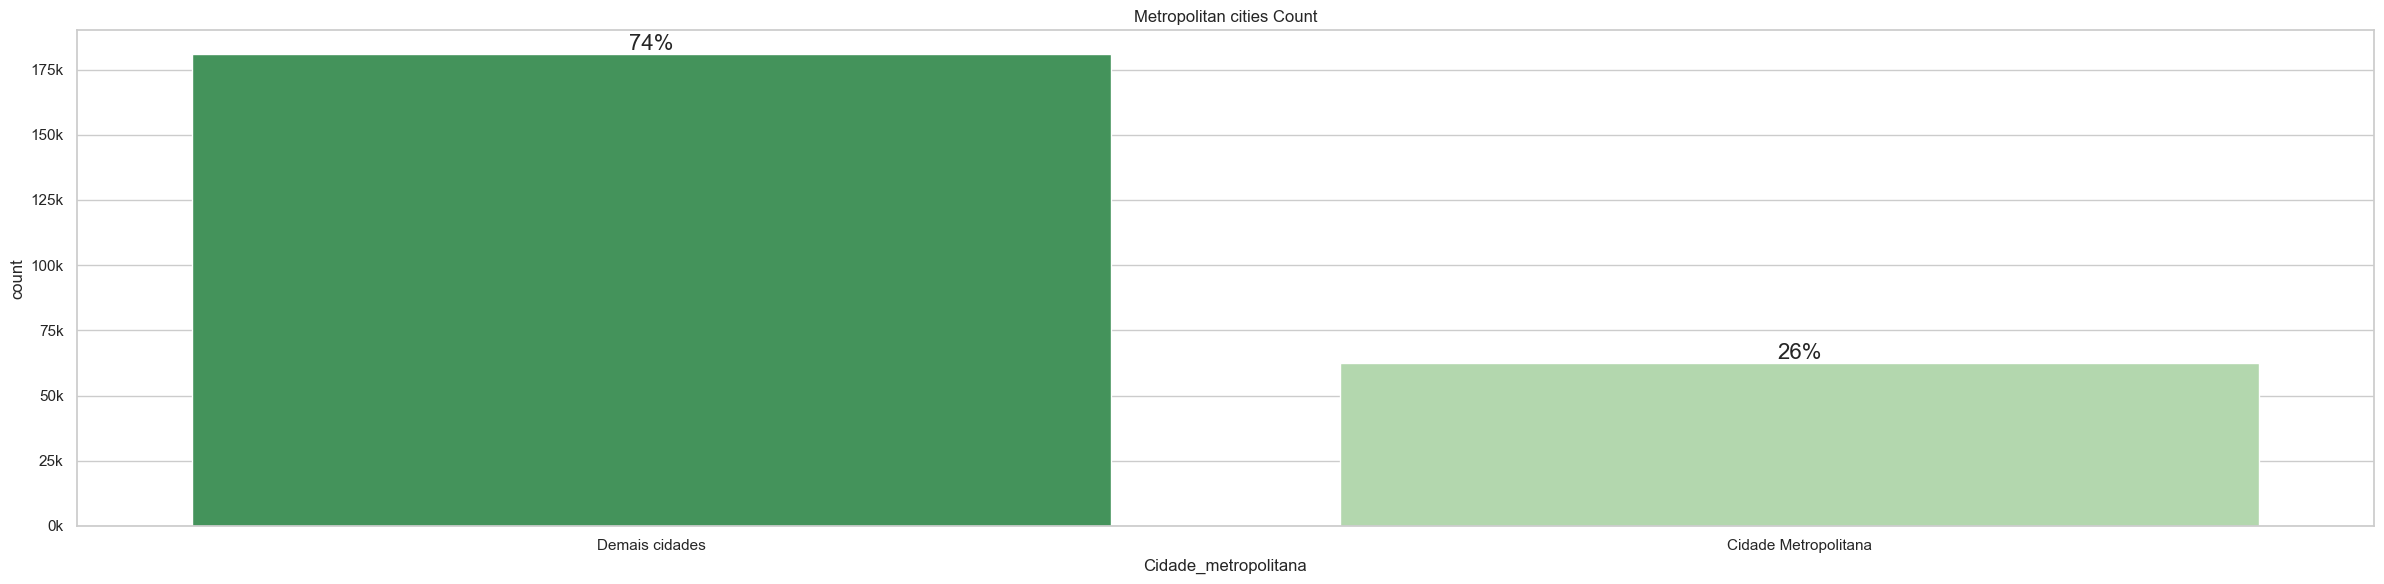

In [71]:
df_aux = df4.copy()
top_5_cidades  = ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Porto Alegre', 'Recife']

df_aux['Cidade_metropolitana'] = df_aux['Cidade'].apply(lambda x: 'Cidade Metropolitana' if x in top_5_cidades else 'Demais cidades')

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(df_aux, 'Cidade_metropolitana', 'Metropolitan cities Count', axs, 0, 16)

plt.tight_layout()
plt.show()

As shown, 74% of the cars are advertised in one of the top 5 metropolitan cities mentioned above.

### 4.2.5. H5 - Owner: Cars owned by legal entities (PJ) are more expensive than those owned by individuals (PF): <span style="color:Red">False</span>

Para realizar essa comparação, foram identificados os carros de mesma versão e ano sendo vendidos tanto por PF como por PJ, para assim comparar o preço. Desconsiderando todos os demais atributos que alteram o preço dos carros.

In [72]:
df_aux = df4.copy()
df_aux['Marca - Modelo - Versao - Ano'] = df_aux.apply(lambda row: ' - '.join(map(str, [row['Marca'], row['Modelo'], row['Versao'], row['AnoModelo']])), axis=1)

tabela_comparativa = pd.pivot_table(df_aux, index='Marca - Modelo - Versao - Ano', columns='TipoVendedor', aggfunc='size', fill_value=0)
tabela_comparativa['Disponibilidade'] = tabela_comparativa.apply(lambda row: 'Ambos' if row['PF'] > 0 and row['PJ'] > 0 else 'Apenas PF' if row['PF'] > 0 else 'Apenas PJ' if row['PJ'] > 0 else 'Nenhum', axis=1)

df_aux2 = tabela_comparativa[tabela_comparativa['Disponibilidade'] == 'Ambos'].reset_index()
carros_vendidos_por_PFePJ = df_aux['Marca - Modelo - Versao - Ano'].unique()

df_aux3 = df_aux[df_aux['Marca - Modelo - Versao - Ano'].isin(carros_vendidos_por_PFePJ)].groupby(['Marca - Modelo - Versao - Ano', 'TipoVendedor'])['Valor'].mean().reset_index()
mean_values = df_aux3.groupby(['Marca - Modelo - Versao - Ano', 'TipoVendedor'])['Valor'].mean().unstack().reset_index()

In [73]:
mean_values.dropna(subset=['PF'], inplace=True)
mean_values.dropna(subset=['PJ'], inplace=True)

In [74]:
mean_values['Maior_Valor'] = mean_values[['PF', 'PJ']].idxmax(axis=1)
mean_values['Variation'] = ((mean_values['PJ'] / mean_values['PF']) - 1 ) * 100

In [75]:
mean_values['Maior_Valor'].value_counts(normalize=True)

Maior_Valor
PJ   0.78
PF   0.22
Name: proportion, dtype: float64

In [76]:
mean_values['Variation'].mean()

5.451735879943529

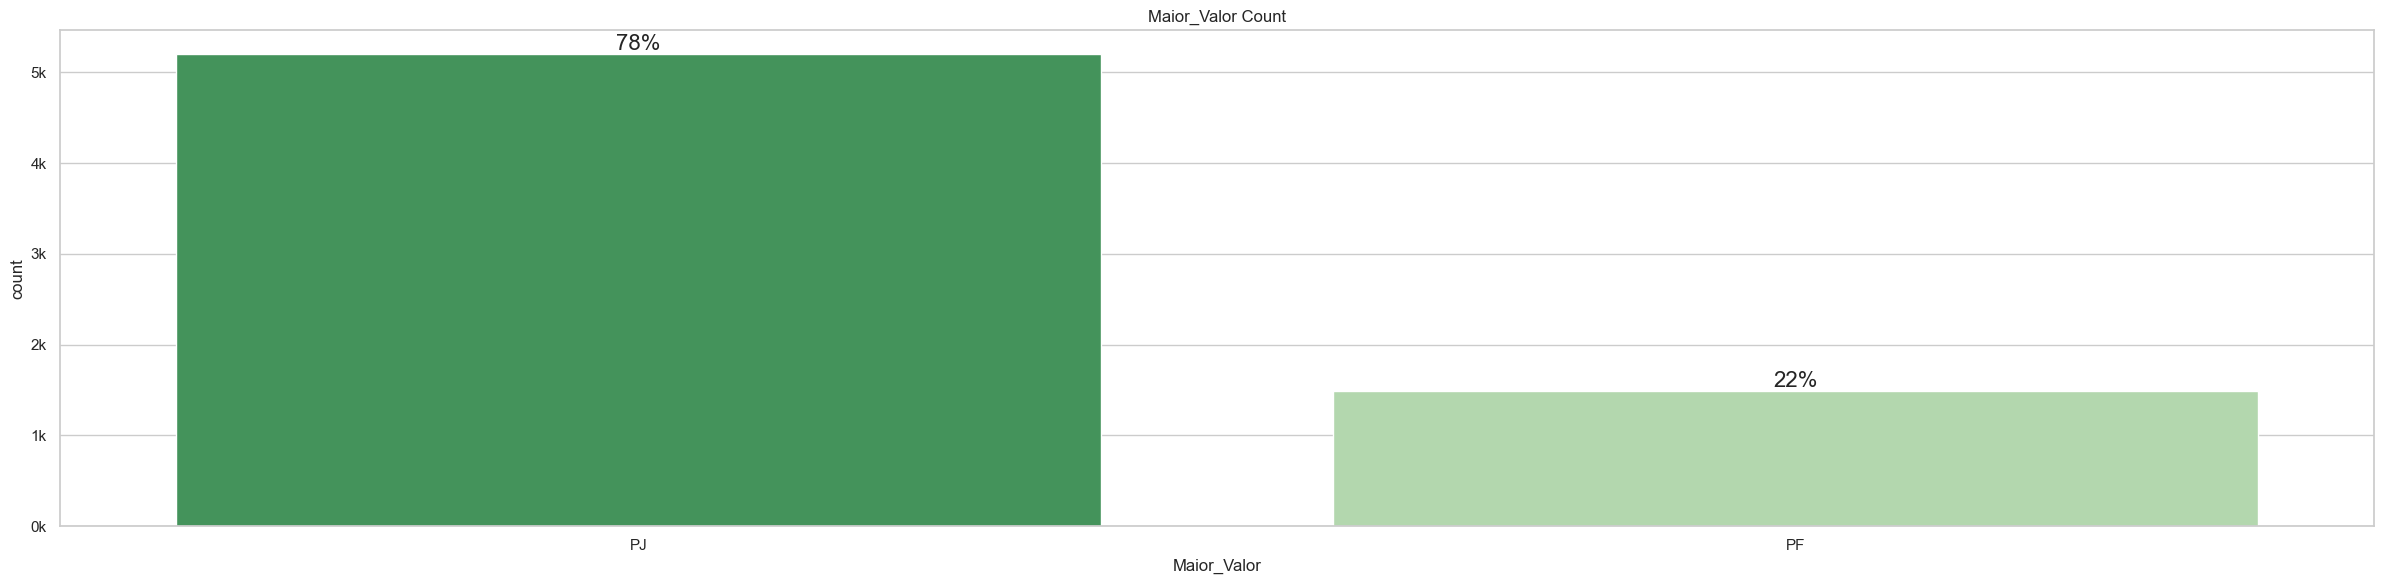

In [77]:
df_aux = df4.copy()

fig, axs = plt.subplots(1, 1, figsize=(24, 6))

plot_count_percentage(mean_values, 'Maior_Valor', 'Maior_Valor Count', axs, 0, 16)

plt.tight_layout()
plt.show()

Como mostra o gráfico, quando comparado o preço médio dos carros anunciados por pessoas físicas contra os de pessoas jurídicas, 78% dos casos o valor é maior para as PJ, com uma média de 5,44%

## 4.2 - Multivaraite Analysis

### 4.2.1. Numerical Attributes

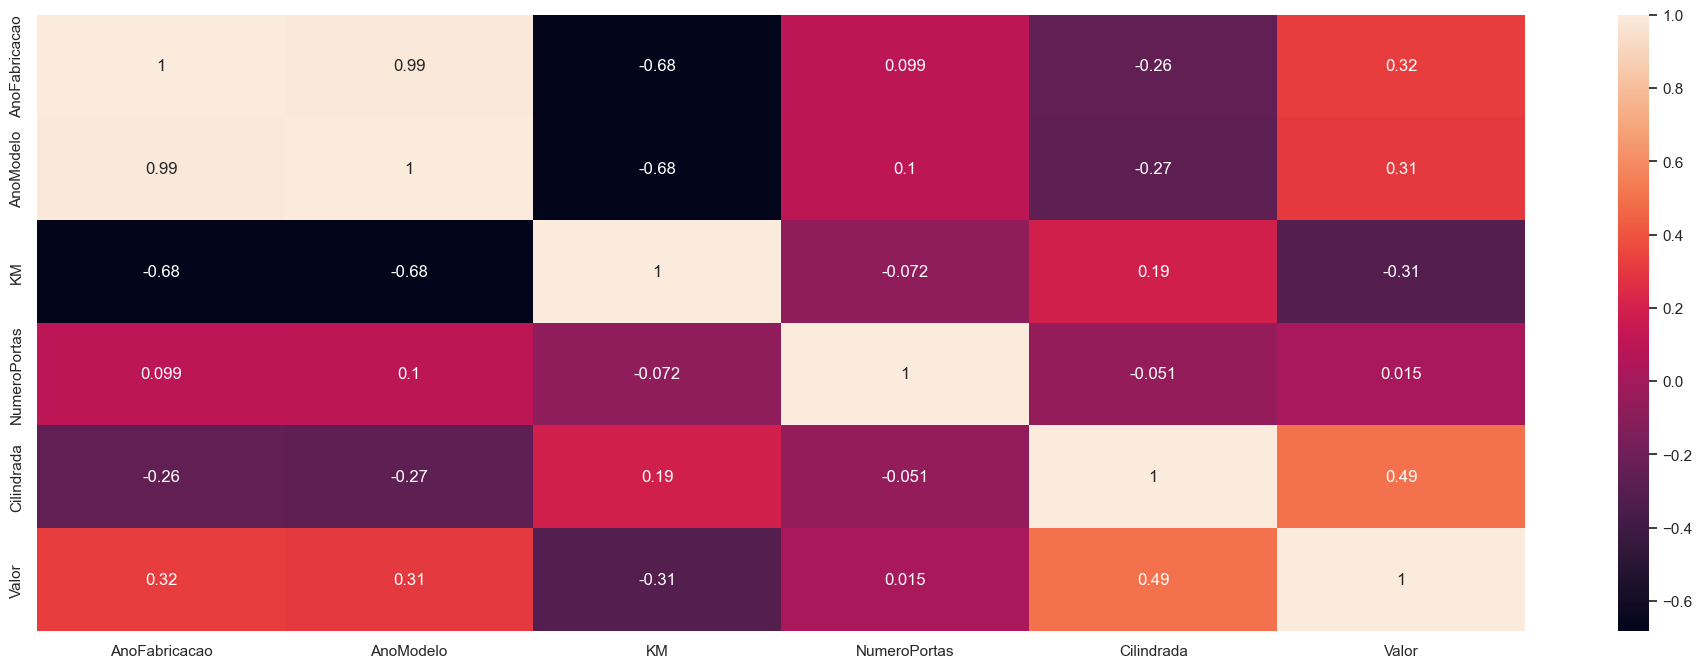

In [78]:
correlation = num_attributes2.corr(method='pearson')
plt.figure(figsize=(24, 8))
sns.heatmap(correlation, annot=True)
plt.show()

Vale lembrar que o ano de fabricação não é levado em consideração, mas, sim, o ano do modelo. Entre os carros envolvidos na pesquisa são excluídos táxis, viaturas, veículos de frota e outros que não se enquadrem no uso comum.

### 4.2.2. Categorical Attributes

In [79]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calcular a correlação de Cramér para cada par de variáveis
cramers_matrix = pd.DataFrame(index=cat_attributes2.columns, columns=cat_attributes2.columns)

for i in cat_attributes2.columns:
    for j in cat_attributes2.columns:
        cramers_matrix.loc[i, j] = cramers_v(cat_attributes2[i], cat_attributes2[j])

# Exibir a matriz de correlação de Cramér
cramers_matrix


,Marca,Modelo,Versao,Estado,Cidade,Cambio,TipoCorpo,UnicoDono,IPVAPago,Licenciado,Blindado,Cor,TipoVendedor,TipoAnuncio,Combustivel
Marca,1.00,1.00,0.99,0.04,0.08,0.29,0.28,0.07,0.06,0.08,0.27,0.09,0.16,0.11,0.34
Modelo,1.00,1.00,0.92,0.05,0.03,0.42,0.92,0.16,0.10,0.11,0.35,0.18,0.23,0.19,0.73
Versao,0.99,0.92,1.00,0.07,0.06,0.54,0.94,0.24,0.15,0.16,0.38,0.24,0.29,0.24,0.99
Estado,0.04,0.05,0.07,1.00,1.00,0.05,0.05,0.17,0.21,0.25,0.15,0.03,0.23,0.14,0.05
Cidade,0.08,0.03,0.06,1.00,1.00,0.10,0.11,0.25,0.31,0.36,0.24,0.08,0.37,0.29,0.10
Cambio,0.29,0.42,0.54,0.05,0.10,1.00,0.25,0.12,0.06,0.07,0.14,0.10,0.16,0.09,0.17
TipoCorpo,0.28,0.92,0.94,0.05,0.11,0.25,1.00,0.08,0.04,0.03,0.13,0.10,0.07,0.07,0.27
UnicoDono,0.07,0.16,0.24,0.17,0.25,0.12,0.08,1.00,0.27,0.20,0.02,0.07,0.18,0.19,0.06
IPVAPago,0.06,0.10,0.15,0.21,0.31,0.06,0.04,0.27,1.00,0.56,0.04,0.04,0.37,0.39,0.05
Licenciado,0.08,0.11,0.16,0.25,0.36,0.07,0.03,0.20,0.56,1.00,0.10,0.05,0.29,0.33,0.07


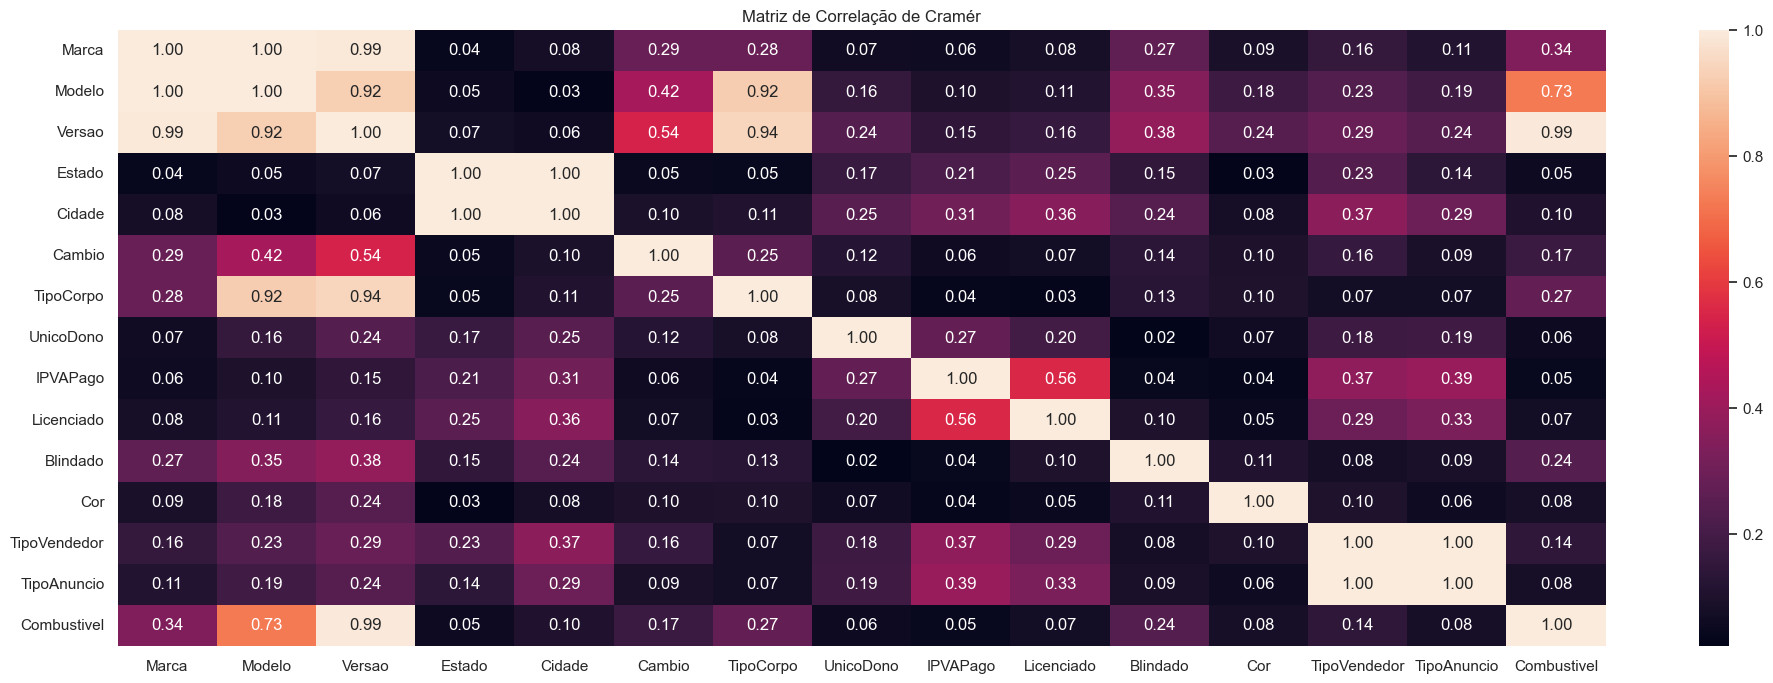

In [80]:
cramers_matrix = cramers_matrix.astype(float)

# Aumentar o tamanho da figura
plt.figure(figsize=(24, 8))

# Criar o mapa de calor com Seaborn
sns.heatmap(cramers_matrix, annot=True, fmt=".2f")

# Adicionar título ao mapa de calor
plt.title("Matriz de Correlação de Cramér")

# Exibir o gráfico
plt.show()

# 5.0 - Data Preparation

In [228]:
df5 = df4.copy()

## 5.1. Rescaling

In [247]:
features = ['AnoFabricacao', 'AnoModelo', 'NumeroPortas', 'Cilindrada']

for feature in features:
    mms = MinMaxScaler()
    df5[feature] = mms.fit_transform(df5[[feature]].values)
    pickle.dump(rs, open(fr'..\\parameter\\{feature}_scaler.pkl', 'wb'))

In [248]:
rs = RobustScaler()

df5['KM'] = rs.fit_transform(df5[['KM']].values)
pickle.dump(rs, open(r'C:\Users\gfurt\Ciência de dados\Projeto do zero\parameter\KM_scaler.pkl', 'wb'))

## 5.2. Encoding

In [260]:
categorical_features = ['Marca', 'Modelo', 'Versao', 'Estado', 'Cidade', 'Cambio', 'TipoCorpo', 'UnicoDono', 'IPVAPago', 'Licenciado', 'Blindado', 'Cor', 'TipoVendedor', 'TipoAnuncio', 'Combustivel']

for feature in categorical_features:
    le = LabelEncoder()
    df5[feature] = le.fit_transform(df5[feature])
    pickle.dump(le, open(fr'..\\parameter\\{feature}_scaler.pkl', 'wb'))

## 5.3. Response Variable Transformation

In [232]:
df5['Valor'] = np.log1p(df5['Valor'])

# 6.0. Feature Selection

In [85]:
df6 = df5.copy()

In [86]:
X_train = df6.drop(columns=['Valor'], axis=1)
y_train = df6['Valor']

## 6.1. REF (Recursive Feature Elimination)

In [87]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
selected_features

Index(['AnoFabricacao', 'AnoModelo', 'KM', 'Cambio', 'NumeroPortas',
       'TipoCorpo', 'Blindado', 'TipoVendedor', 'TipoAnuncio', 'Cilindrada'],
      dtype='object')

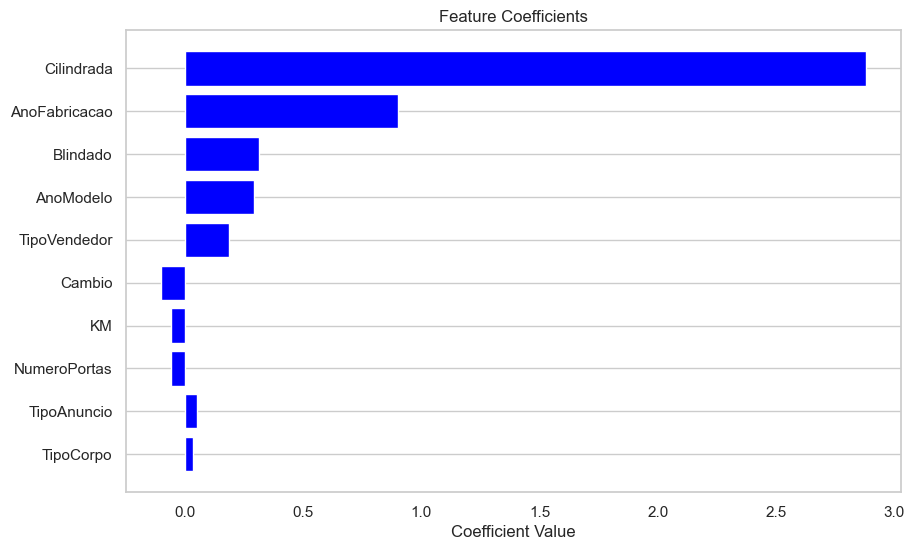

In [88]:
# Criar um novo modelo apenas com as features selecionadas
model_selected_features = LinearRegression()
model_selected_features.fit(X_train[selected_features], y_train)

coefficients = model_selected_features.coef_
selected_features_info = pd.DataFrame({'Feature': selected_features, 'Coefficient': coefficients})
selected_features_info['Absolute_Coefficient'] = selected_features_info['Coefficient'].abs()
sorted_features_info = selected_features_info.sort_values(by='Absolute_Coefficient', ascending=False)

# Plotar um gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_info['Feature'], sorted_features_info['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

## 6.2. Xgboost selector

<Figure size 1000x600 with 0 Axes>

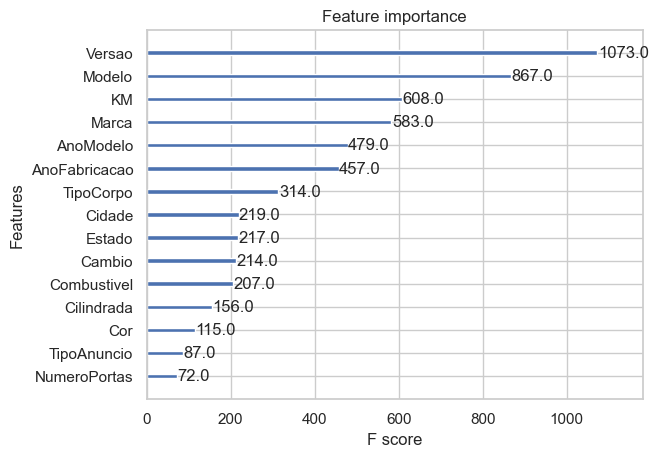

In [89]:
# Supondo que você tenha os conjuntos de treino X_train e y_train
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Plotar as importâncias das features
plt.figure(figsize=(10, 6))
plot_importance(model_xgb, importance_type='weight', max_num_features=15)  # Pode ajustar max_num_features conforme necessário
plt.show()


In [90]:
['AnoModelo', 'NumeroPortas', 'TipoCorpo', 'UnicoDono','IPVAPago', 'Licenciado', 'TipoVendedor', 'TipoAnuncio', 'Combustivel', 'Cilindrada']

['AnoModelo',
 'NumeroPortas',
 'TipoCorpo',
 'UnicoDono',
 'IPVAPago',
 'Licenciado',
 'TipoVendedor',
 'TipoAnuncio',
 'Combustivel',
 'Cilindrada']

## 6.3. Lasso Feature selection

In [91]:
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

lasso_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso_model.coef_})

lasso_coef_sorted = lasso_coef.iloc[np.abs(lasso_coef['Coefficient']).argsort()[::-1]]
lasso_coef_sorted.head(10)

,Feature,Coefficient
4,AnoModelo,0.63
3,AnoFabricacao,0.18
7,KM,-0.12
8,Cambio,-0.09
10,TipoCorpo,0.03
15,Cor,-0.00
0,Marca,-0.00
2,Versao,0.00
1,Modelo,0.00
6,Cidade,-0.00


## 6.4. Selected features

In [92]:
# Manter: ['Marca', 'Modelo', 'Versao', 'AnoFabricacao', 'KM', 'Cambio', 'Blindado', 'Cor', 'Estado', 'Cidade']

# Retirar: AnoModelo:    Redundante. AnoFabricação foi melhor pontuado
#          NumeroPortas: Irrelevante. Depois de determinado o modelo do carro o NumeroPortas não varia
#          TipoCorpo:    Irrelevante. Depois de determinado o modelo do carro o TipoCorpo não varia
#          Cilindrada:   Variável derivada da versão, a qual foi melhor pontuada nos algoritimos de seleção de features
#          Combustivel:  Variável derivada da versão, a qual foi melhor pontuada nos algoritimos de seleção de features
#          UnicoDono:    Não foi identificado nenhuma relevância
#          IPVAPago:     Não foi identificado nenhuma relevância
#          Licenciado:   Não foi identificado nenhuma relevância
#          TipoVendedor: Não foi identificado nenhuma relevância
#          TipoAnuncio:  Não foi identificado nenhuma relevância

# 7.0. Machine Learning Model

# 8.0 - Hyperparameter Fine Tunning

# 9.0 - Model Performance

# 10.0. Deploy